In [1]:
from absl import logging

# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import cv2 # for capturing videos
import numpy as np
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
from keras.preprocessing import image   # for preprocessing the images
from keras.preprocessing.image import array_to_img
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

In [ ]:
TRAIN_FOLDER_PATH = r'C:\\Users\djcoo\Documents\LYIT\Final\project\RWF-2000_test\train'
TEST_FOLDER_PATH = r'C:\\Users\djcoo\Documents\LYIT\Final\project\RWF-2000_test\val'

def listDir(dir):
    catgeory = {}
    dirNames = os.listdir(dir)
    for dirName in dirNames:
        catgeory[dirName] = []
#         print('Directory Name : '+ dirName)
        dir_path = os.path.abspath(os.path.join(dir, dirName))
#         print('Directory Path : '+ dir_path)
        fileNames = os.listdir(dir_path)
        for fileName in fileNames:
            file_path = os.path.abspath(os.path.join(dir_path, fileName))
#             print('File Path : '+ file_path )
            catgeory[dirName].append(file_path)
    return catgeory

LIST_OF_TRAIN_CATEGORY = listDir(TRAIN_FOLDER_PATH)

In [ ]:
LIST_OF_TEST_CATEGORY = listDir(TEST_FOLDER_PATH)

In [ ]:
video_path = LIST_OF_TRAIN_CATEGORY["Fight"][0]
sample_video = load_video(video_path)
sample_video.shape

In [ ]:
video_path = LIST_OF_TEST_CATEGORY["Fight"][0]
sample_video = load_video(video_path)
sample_video.shape

In [ ]:
video_path = LIST_OF_TRAIN_CATEGORY["NonFight"][0]
sample_video = load_video(video_path)
sample_video.shape

In [ ]:
video_path = LIST_OF_TEST_CATEGORY["NonFight"][0]
sample_video = load_video(video_path)
sample_video.shape

In [ ]:
def get_video_frames(path_arr, flag):
    label_arr = ["Fight", "NonFight"]
    for label in label_arr:
        image_count = 0
        for video_path in tqdm(path_arr[label]):
#             video_name = video_path.split('\\').pop().split(".")[0]
        #     print(video_name)
            cap = cv2.VideoCapture(video_path)   # capturing the video from the given path
            frameRate = cap.get(5) #frame rate
            frame_count = 0
            while(cap.isOpened()):
                frameId = cap.get(1) #current frame number
                ret, frame = cap.read()
                if (ret != True):
                    break
                if (frameId % math.floor(frameRate) == 0):
                    # storing the frames in a new folder named train_1
                    TRAIN_FRAME_PATH = "C:\\Users\\djcoo\\Documents\\LYIT\\Final\\project\\frames\\"+ flag +"\\" + label + "_"
#                     filename = r"%s" %TRAIN_FRAME_PATH + video_name +"_frame%d.jpg" %frame_count;
                    filename = r"%s" %TRAIN_FRAME_PATH + "%d"%image_count +"_frame%d.jpg" %frame_count
#                     print(filename)
                    frame_count+=1
                    cv2.imwrite(filename, frame)
            image_count+=1
            cap.release()

In [ ]:
get_video_frames(LIST_OF_TRAIN_CATEGORY, "train")

In [ ]:
get_video_frames(LIST_OF_TEST_CATEGORY, "test")

In [2]:
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D


In [3]:
import random
images = glob(r"C:\\Users\\djcoo\\Documents\\LYIT\\Final\\project\\frames_main\\train\\*.jpg")
# creating an empty list
random.shuffle(images)

train_image = []
train_class = []

# for loop to read and store frames
for img_path in tqdm(images):
    # loading the image and keeping the target size as (224,224,3)
#     img = image.load_img(img_path, target_size=(224,224,3))
#     # converting it to array
#     img = image.img_to_array(img)
#     # normalizing the pixel value
#     img = img/255
#     # appending the image to the train_image list
#     print(img_path) 
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    train_image.append(image)
    train_class.append(img_path.split("\\").pop().split("_")[0])
    
# converting the list to numpy array
X_train = np.array(train_image)

# shape of the array
X_train.shape

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:48<00:00, 164.70it/s]


(8000, 224, 224, 3)

(224, 224, 3)


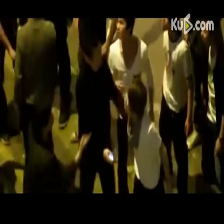

In [4]:
print(X_train[0].shape) 
array_to_img(X_train[0])

In [5]:
images = glob(r"C:\\Users\\djcoo\\Documents\\LYIT\\Final\\project\\frames_main\\test\\*.jpg")
# creating an empty list
random.shuffle(images)

test_image = []
test_class = []

# for loop to read and store frames
for img_path in tqdm(images):
#     # loading the image and keeping the target size as (224,224,3)
#     img = image.load_img(img_path, target_size=(224,224,3))
#     # converting it to array
#     img = image.img_to_array(img)
#     # normalizing the pixel value
#     img = img/255
    # appending the image to the train_image list
#     print(img_path) 
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = cv2.resize(image, (224, 224))
    
    test_image.append(image)
    test_class.append(img_path.split("\\").pop().split("_")[0])
    
# converting the list to numpy array
X_test = np.array(test_image)

# shape of the array
X_test.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 152.38it/s]


(2000, 224, 224, 3)

(224, 224, 3)


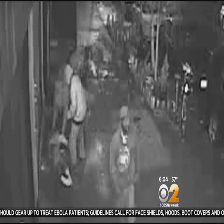

In [6]:
print(X_test[-1].shape) 
array_to_img(X_test[-1])

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import argparse
import pickle
import sys; sys.argv=['']; del sys

In [8]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
#     help="path to input dataset")
# ap.add_argument("-m", "--model", required=True,
#     help="path to output serialized model")
# ap.add_argument("-l", "--label-bin", required=True,
#     help="path to output label binarizer")
# ap.add_argument("-e", "--epochs", type=int, default=25,
#     help="# of epochs to train our network for")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
#     help="path to output loss/accuracy plot")
# args = vars(ap.parse_args())

In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
y_train = to_categorical(lb.fit_transform(train_class))
y_test = to_categorical(lb.fit_transform(test_class))

# print(len(y_test))

In [10]:
# len(X_test)//28

In [11]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [12]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

In [13]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
epcohs = 50
print("[INFO] compiling model...")
opt =  (lr=1e-4, momentum=0.9, decay=1e-4 / epcohs)
# opt = SGD(lr=0.00005, momentum=0.9, decay=1e-6)# epcohs 25
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
batch = 32 #32
H = model.fit(
	x=trainAug.flow(X_train, y_train, batch_size=batch),
	steps_per_epoch=len(X_train) // batch,
	validation_data=valAug.flow(X_test, y_test),
	validation_steps=len(X_test) // batch,
	epochs=epcohs) # epcohs 25

[INFO] compiling model...
[INFO] training head...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 250 steps, validate for 62 steps
Epoch 1/50


184/250 [=====================>........] - ETA: 24:02 - loss: 1.0470 - accuracy: 0.531 - ETA: 17:43 - loss: 1.1812 - accuracy: 0.500 - ETA: 15:25 - loss: 1.2617 - accuracy: 0.468 - ETA: 14:14 - loss: 1.2253 - accuracy: 0.468 - ETA: 13:38 - loss: 1.2247 - accuracy: 0.450 - ETA: 13:13 - loss: 1.2067 - accuracy: 0.463 - ETA: 12:49 - loss: 1.2289 - accuracy: 0.455 - ETA: 12:31 - loss: 1.2272 - accuracy: 0.449 - ETA: 12:15 - loss: 1.1889 - accuracy: 0.465 - ETA: 12:04 - loss: 1.1565 - accuracy: 0.471 - ETA: 11:52 - loss: 1.1407 - accuracy: 0.480 - ETA: 11:44 - loss: 1.1329 - accuracy: 0.476 - ETA: 11:35 - loss: 1.1048 - accuracy: 0.483 - ETA: 11:27 - loss: 1.0854 - accuracy: 0.491 - ETA: 11:20 - loss: 1.0576 - accuracy: 0.502 - ETA: 11:14 - loss: 1.0422 - accuracy: 0.502 - ETA: 11:12 - loss: 1.0384 - accuracy: 0.498 - ETA: 11:09 - loss: 1.0272 - accuracy: 0.505 - ETA: 11:07 - loss: 1.0104 - accuracy: 0.511 - ETA: 11:08 - loss: 0.9991 - accuracy: 0.514 - ETA: 11:11 - loss: 0.9992 - accuracy:

185/250 [=====================>........] - ETA: 12:42 - loss: 0.6723 - accuracy: 0.625 - ETA: 12:03 - loss: 0.6607 - accuracy: 0.625 - ETA: 11:32 - loss: 0.6278 - accuracy: 0.645 - ETA: 11:14 - loss: 0.6301 - accuracy: 0.664 - ETA: 11:04 - loss: 0.6492 - accuracy: 0.643 - ETA: 10:57 - loss: 0.6471 - accuracy: 0.640 - ETA: 10:51 - loss: 0.6628 - accuracy: 0.633 - ETA: 10:45 - loss: 0.6415 - accuracy: 0.640 - ETA: 10:40 - loss: 0.6342 - accuracy: 0.642 - ETA: 10:37 - loss: 0.6250 - accuracy: 0.653 - ETA: 10:33 - loss: 0.6171 - accuracy: 0.656 - ETA: 10:29 - loss: 0.6309 - accuracy: 0.640 - ETA: 10:26 - loss: 0.6323 - accuracy: 0.641 - ETA: 10:25 - loss: 0.6374 - accuracy: 0.636 - ETA: 10:21 - loss: 0.6370 - accuracy: 0.635 - ETA: 10:18 - loss: 0.6364 - accuracy: 0.636 - ETA: 10:16 - loss: 0.6364 - accuracy: 0.636 - ETA: 10:14 - loss: 0.6375 - accuracy: 0.638 - ETA: 10:10 - loss: 0.6454 - accuracy: 0.629 - ETA: 10:06 - loss: 0.6455 - accuracy: 0.629 - ETA: 10:03 - loss: 0.6507 - accuracy:

250/250 [==============================] - ETA: 2:46 - loss: 0.6684 - accuracy: 0.63 - ETA: 2:43 - loss: 0.6684 - accuracy: 0.63 - ETA: 2:40 - loss: 0.6679 - accuracy: 0.63 - ETA: 2:38 - loss: 0.6672 - accuracy: 0.63 - ETA: 2:35 - loss: 0.6673 - accuracy: 0.63 - ETA: 2:33 - loss: 0.6665 - accuracy: 0.63 - ETA: 2:30 - loss: 0.6668 - accuracy: 0.63 - ETA: 2:27 - loss: 0.6667 - accuracy: 0.63 - ETA: 2:25 - loss: 0.6663 - accuracy: 0.63 - ETA: 2:22 - loss: 0.6659 - accuracy: 0.63 - ETA: 2:20 - loss: 0.6656 - accuracy: 0.63 - ETA: 2:17 - loss: 0.6659 - accuracy: 0.63 - ETA: 2:14 - loss: 0.6657 - accuracy: 0.63 - ETA: 2:12 - loss: 0.6658 - accuracy: 0.63 - ETA: 2:09 - loss: 0.6665 - accuracy: 0.63 - ETA: 2:07 - loss: 0.6670 - accuracy: 0.63 - ETA: 2:04 - loss: 0.6670 - accuracy: 0.63 - ETA: 2:01 - loss: 0.6666 - accuracy: 0.63 - ETA: 1:59 - loss: 0.6671 - accuracy: 0.63 - ETA: 1:56 - loss: 0.6666 - accuracy: 0.63 - ETA: 1:54 - loss: 0.6656 - accuracy: 0.63 - ETA: 1:51 - loss: 0.6656 - accura

185/250 [=====================>........] - ETA: 12:40 - loss: 0.5428 - accuracy: 0.718 - ETA: 12:02 - loss: 0.5785 - accuracy: 0.687 - ETA: 11:33 - loss: 0.6031 - accuracy: 0.687 - ETA: 11:14 - loss: 0.6260 - accuracy: 0.656 - ETA: 11:04 - loss: 0.6450 - accuracy: 0.643 - ETA: 10:56 - loss: 0.6403 - accuracy: 0.645 - ETA: 10:50 - loss: 0.6334 - accuracy: 0.651 - ETA: 10:45 - loss: 0.6289 - accuracy: 0.652 - ETA: 10:40 - loss: 0.6233 - accuracy: 0.656 - ETA: 10:35 - loss: 0.6150 - accuracy: 0.662 - ETA: 10:34 - loss: 0.6201 - accuracy: 0.656 - ETA: 10:29 - loss: 0.6170 - accuracy: 0.658 - ETA: 10:26 - loss: 0.6168 - accuracy: 0.658 - ETA: 10:24 - loss: 0.6112 - accuracy: 0.665 - ETA: 10:20 - loss: 0.6233 - accuracy: 0.656 - ETA: 10:16 - loss: 0.6244 - accuracy: 0.656 - ETA: 10:13 - loss: 0.6255 - accuracy: 0.656 - ETA: 10:10 - loss: 0.6191 - accuracy: 0.663 - ETA: 10:06 - loss: 0.6123 - accuracy: 0.671 - ETA: 10:03 - loss: 0.6080 - accuracy: 0.671 - ETA: 10:00 - loss: 0.6030 - accuracy:

185/250 [=====================>........] - ETA: 12:37 - loss: 0.5731 - accuracy: 0.781 - ETA: 11:59 - loss: 0.6027 - accuracy: 0.734 - ETA: 11:29 - loss: 0.5775 - accuracy: 0.750 - ETA: 11:13 - loss: 0.5719 - accuracy: 0.742 - ETA: 11:04 - loss: 0.5821 - accuracy: 0.731 - ETA: 10:56 - loss: 0.5761 - accuracy: 0.734 - ETA: 10:49 - loss: 0.5697 - accuracy: 0.741 - ETA: 10:42 - loss: 0.5468 - accuracy: 0.750 - ETA: 10:37 - loss: 0.5453 - accuracy: 0.753 - ETA: 10:32 - loss: 0.5438 - accuracy: 0.753 - ETA: 10:28 - loss: 0.5376 - accuracy: 0.755 - ETA: 10:25 - loss: 0.5503 - accuracy: 0.742 - ETA: 10:20 - loss: 0.5560 - accuracy: 0.735 - ETA: 10:17 - loss: 0.5589 - accuracy: 0.729 - ETA: 10:13 - loss: 0.5696 - accuracy: 0.725 - ETA: 10:11 - loss: 0.5763 - accuracy: 0.714 - ETA: 10:08 - loss: 0.5715 - accuracy: 0.713 - ETA: 10:05 - loss: 0.5835 - accuracy: 0.704 - ETA: 10:03 - loss: 0.5838 - accuracy: 0.703 - ETA: 9:59 - loss: 0.5956 - accuracy: 0.698 - ETA: 9:57 - loss: 0.5970 - accuracy: 0

250/250 [==============================] - ETA: 2:45 - loss: 0.6082 - accuracy: 0.67 - ETA: 2:42 - loss: 0.6079 - accuracy: 0.67 - ETA: 2:40 - loss: 0.6083 - accuracy: 0.67 - ETA: 2:37 - loss: 0.6082 - accuracy: 0.67 - ETA: 2:34 - loss: 0.6078 - accuracy: 0.67 - ETA: 2:32 - loss: 0.6071 - accuracy: 0.67 - ETA: 2:29 - loss: 0.6077 - accuracy: 0.67 - ETA: 2:27 - loss: 0.6073 - accuracy: 0.67 - ETA: 2:24 - loss: 0.6073 - accuracy: 0.67 - ETA: 2:22 - loss: 0.6075 - accuracy: 0.67 - ETA: 2:19 - loss: 0.6076 - accuracy: 0.67 - ETA: 2:16 - loss: 0.6076 - accuracy: 0.67 - ETA: 2:14 - loss: 0.6078 - accuracy: 0.67 - ETA: 2:11 - loss: 0.6077 - accuracy: 0.67 - ETA: 2:09 - loss: 0.6080 - accuracy: 0.67 - ETA: 2:06 - loss: 0.6075 - accuracy: 0.67 - ETA: 2:03 - loss: 0.6073 - accuracy: 0.67 - ETA: 2:01 - loss: 0.6077 - accuracy: 0.67 - ETA: 1:58 - loss: 0.6077 - accuracy: 0.67 - ETA: 1:56 - loss: 0.6072 - accuracy: 0.67 - ETA: 1:53 - loss: 0.6073 - accuracy: 0.67 - ETA: 1:51 - loss: 0.6071 - accura

185/250 [=====================>........] - ETA: 12:33 - loss: 0.5471 - accuracy: 0.812 - ETA: 11:49 - loss: 0.5803 - accuracy: 0.750 - ETA: 11:27 - loss: 0.5600 - accuracy: 0.760 - ETA: 11:14 - loss: 0.5553 - accuracy: 0.757 - ETA: 11:03 - loss: 0.5598 - accuracy: 0.762 - ETA: 10:57 - loss: 0.5770 - accuracy: 0.734 - ETA: 10:49 - loss: 0.5821 - accuracy: 0.727 - ETA: 10:43 - loss: 0.5824 - accuracy: 0.734 - ETA: 10:38 - loss: 0.5866 - accuracy: 0.718 - ETA: 10:33 - loss: 0.5757 - accuracy: 0.725 - ETA: 10:30 - loss: 0.5835 - accuracy: 0.721 - ETA: 10:25 - loss: 0.5870 - accuracy: 0.713 - ETA: 10:23 - loss: 0.5881 - accuracy: 0.709 - ETA: 10:20 - loss: 0.5808 - accuracy: 0.714 - ETA: 10:17 - loss: 0.5870 - accuracy: 0.712 - ETA: 10:14 - loss: 0.5904 - accuracy: 0.710 - ETA: 10:11 - loss: 0.5881 - accuracy: 0.713 - ETA: 10:08 - loss: 0.5882 - accuracy: 0.711 - ETA: 10:05 - loss: 0.5853 - accuracy: 0.712 - ETA: 10:02 - loss: 0.5905 - accuracy: 0.704 - ETA: 10:00 - loss: 0.5918 - accuracy:

185/250 [=====================>........] - ETA: 12:57 - loss: 0.6995 - accuracy: 0.593 - ETA: 12:10 - loss: 0.6393 - accuracy: 0.640 - ETA: 11:45 - loss: 0.5880 - accuracy: 0.677 - ETA: 11:27 - loss: 0.5444 - accuracy: 0.718 - ETA: 11:14 - loss: 0.5800 - accuracy: 0.706 - ETA: 11:03 - loss: 0.6197 - accuracy: 0.687 - ETA: 10:56 - loss: 0.6029 - accuracy: 0.692 - ETA: 10:50 - loss: 0.5973 - accuracy: 0.695 - ETA: 10:43 - loss: 0.5850 - accuracy: 0.711 - ETA: 10:37 - loss: 0.5980 - accuracy: 0.700 - ETA: 10:34 - loss: 0.5979 - accuracy: 0.698 - ETA: 10:29 - loss: 0.5923 - accuracy: 0.697 - ETA: 10:25 - loss: 0.6054 - accuracy: 0.685 - ETA: 10:21 - loss: 0.5996 - accuracy: 0.685 - ETA: 10:18 - loss: 0.6034 - accuracy: 0.679 - ETA: 10:15 - loss: 0.5962 - accuracy: 0.683 - ETA: 10:12 - loss: 0.5932 - accuracy: 0.685 - ETA: 10:09 - loss: 0.5913 - accuracy: 0.687 - ETA: 10:07 - loss: 0.5947 - accuracy: 0.685 - ETA: 10:03 - loss: 0.5958 - accuracy: 0.682 - ETA: 10:00 - loss: 0.5977 - accuracy:

250/250 [==============================] - ETA: 2:46 - loss: 0.5808 - accuracy: 0.69 - ETA: 2:43 - loss: 0.5809 - accuracy: 0.69 - ETA: 2:41 - loss: 0.5818 - accuracy: 0.69 - ETA: 2:38 - loss: 0.5820 - accuracy: 0.69 - ETA: 2:35 - loss: 0.5818 - accuracy: 0.69 - ETA: 2:33 - loss: 0.5823 - accuracy: 0.69 - ETA: 2:30 - loss: 0.5823 - accuracy: 0.69 - ETA: 2:28 - loss: 0.5819 - accuracy: 0.69 - ETA: 2:25 - loss: 0.5826 - accuracy: 0.69 - ETA: 2:22 - loss: 0.5832 - accuracy: 0.68 - ETA: 2:20 - loss: 0.5840 - accuracy: 0.68 - ETA: 2:17 - loss: 0.5839 - accuracy: 0.68 - ETA: 2:15 - loss: 0.5834 - accuracy: 0.68 - ETA: 2:12 - loss: 0.5840 - accuracy: 0.68 - ETA: 2:09 - loss: 0.5837 - accuracy: 0.68 - ETA: 2:07 - loss: 0.5833 - accuracy: 0.68 - ETA: 2:04 - loss: 0.5829 - accuracy: 0.69 - ETA: 2:02 - loss: 0.5824 - accuracy: 0.69 - ETA: 1:59 - loss: 0.5827 - accuracy: 0.69 - ETA: 1:56 - loss: 0.5827 - accuracy: 0.69 - ETA: 1:54 - loss: 0.5827 - accuracy: 0.69 - ETA: 1:51 - loss: 0.5834 - accura

185/250 [=====================>........] - ETA: 12:26 - loss: 0.5486 - accuracy: 0.687 - ETA: 11:50 - loss: 0.5209 - accuracy: 0.750 - ETA: 11:25 - loss: 0.5184 - accuracy: 0.729 - ETA: 11:10 - loss: 0.5696 - accuracy: 0.695 - ETA: 11:01 - loss: 0.5700 - accuracy: 0.693 - ETA: 10:52 - loss: 0.5678 - accuracy: 0.682 - ETA: 10:47 - loss: 0.5704 - accuracy: 0.687 - ETA: 10:39 - loss: 0.5795 - accuracy: 0.679 - ETA: 10:34 - loss: 0.5963 - accuracy: 0.673 - ETA: 10:31 - loss: 0.5895 - accuracy: 0.671 - ETA: 10:28 - loss: 0.5935 - accuracy: 0.667 - ETA: 10:25 - loss: 0.5862 - accuracy: 0.669 - ETA: 10:21 - loss: 0.5879 - accuracy: 0.665 - ETA: 10:17 - loss: 0.6030 - accuracy: 0.658 - ETA: 10:15 - loss: 0.5955 - accuracy: 0.664 - ETA: 10:11 - loss: 0.5911 - accuracy: 0.671 - ETA: 10:09 - loss: 0.5828 - accuracy: 0.680 - ETA: 10:06 - loss: 0.5824 - accuracy: 0.677 - ETA: 10:03 - loss: 0.5777 - accuracy: 0.680 - ETA: 9:59 - loss: 0.5798 - accuracy: 0.679 - ETA: 9:57 - loss: 0.5802 - accuracy: 0

185/250 [=====================>........] - ETA: 12:40 - loss: 0.5353 - accuracy: 0.718 - ETA: 12:03 - loss: 0.5600 - accuracy: 0.703 - ETA: 11:28 - loss: 0.5516 - accuracy: 0.729 - ETA: 11:14 - loss: 0.5892 - accuracy: 0.695 - ETA: 11:01 - loss: 0.5732 - accuracy: 0.700 - ETA: 10:54 - loss: 0.5703 - accuracy: 0.697 - ETA: 10:47 - loss: 0.5687 - accuracy: 0.705 - ETA: 10:43 - loss: 0.5928 - accuracy: 0.699 - ETA: 10:39 - loss: 0.5840 - accuracy: 0.701 - ETA: 10:35 - loss: 0.5822 - accuracy: 0.700 - ETA: 10:30 - loss: 0.5848 - accuracy: 0.696 - ETA: 10:26 - loss: 0.5943 - accuracy: 0.690 - ETA: 10:23 - loss: 0.6002 - accuracy: 0.689 - ETA: 10:20 - loss: 0.5919 - accuracy: 0.694 - ETA: 10:16 - loss: 0.5883 - accuracy: 0.691 - ETA: 10:13 - loss: 0.5873 - accuracy: 0.695 - ETA: 10:10 - loss: 0.5934 - accuracy: 0.687 - ETA: 10:07 - loss: 0.5932 - accuracy: 0.691 - ETA: 10:04 - loss: 0.5913 - accuracy: 0.692 - ETA: 10:01 - loss: 0.5836 - accuracy: 0.700 - ETA: 9:59 - loss: 0.5851 - accuracy: 

250/250 [==============================] - ETA: 2:45 - loss: 0.5655 - accuracy: 0.70 - ETA: 2:43 - loss: 0.5649 - accuracy: 0.70 - ETA: 2:40 - loss: 0.5649 - accuracy: 0.70 - ETA: 2:37 - loss: 0.5652 - accuracy: 0.70 - ETA: 2:35 - loss: 0.5658 - accuracy: 0.70 - ETA: 2:32 - loss: 0.5650 - accuracy: 0.70 - ETA: 2:30 - loss: 0.5657 - accuracy: 0.70 - ETA: 2:27 - loss: 0.5648 - accuracy: 0.70 - ETA: 2:25 - loss: 0.5651 - accuracy: 0.70 - ETA: 2:22 - loss: 0.5664 - accuracy: 0.70 - ETA: 2:19 - loss: 0.5661 - accuracy: 0.70 - ETA: 2:17 - loss: 0.5659 - accuracy: 0.70 - ETA: 2:14 - loss: 0.5659 - accuracy: 0.70 - ETA: 2:12 - loss: 0.5658 - accuracy: 0.70 - ETA: 2:09 - loss: 0.5651 - accuracy: 0.70 - ETA: 2:06 - loss: 0.5656 - accuracy: 0.70 - ETA: 2:04 - loss: 0.5644 - accuracy: 0.70 - ETA: 2:01 - loss: 0.5642 - accuracy: 0.70 - ETA: 1:59 - loss: 0.5643 - accuracy: 0.70 - ETA: 1:56 - loss: 0.5645 - accuracy: 0.70 - ETA: 1:53 - loss: 0.5650 - accuracy: 0.70 - ETA: 1:51 - loss: 0.5652 - accura

185/250 [=====================>........] - ETA: 12:24 - loss: 0.5439 - accuracy: 0.656 - ETA: 11:50 - loss: 0.5388 - accuracy: 0.687 - ETA: 11:22 - loss: 0.5511 - accuracy: 0.697 - ETA: 11:10 - loss: 0.5794 - accuracy: 0.710 - ETA: 10:58 - loss: 0.5516 - accuracy: 0.731 - ETA: 10:50 - loss: 0.5498 - accuracy: 0.734 - ETA: 10:44 - loss: 0.5502 - accuracy: 0.732 - ETA: 10:40 - loss: 0.5624 - accuracy: 0.734 - ETA: 10:34 - loss: 0.5743 - accuracy: 0.711 - ETA: 10:31 - loss: 0.5694 - accuracy: 0.706 - ETA: 10:26 - loss: 0.5635 - accuracy: 0.707 - ETA: 10:24 - loss: 0.5594 - accuracy: 0.705 - ETA: 10:20 - loss: 0.5611 - accuracy: 0.709 - ETA: 10:17 - loss: 0.5693 - accuracy: 0.700 - ETA: 10:14 - loss: 0.5717 - accuracy: 0.695 - ETA: 10:11 - loss: 0.5747 - accuracy: 0.695 - ETA: 10:08 - loss: 0.5729 - accuracy: 0.702 - ETA: 10:05 - loss: 0.5703 - accuracy: 0.708 - ETA: 10:02 - loss: 0.5652 - accuracy: 0.712 - ETA: 9:59 - loss: 0.5663 - accuracy: 0.710 - ETA: 9:56 - loss: 0.5696 - accuracy: 0

185/250 [=====================>........] - ETA: 12:48 - loss: 0.4845 - accuracy: 0.718 - ETA: 12:03 - loss: 0.4876 - accuracy: 0.796 - ETA: 11:36 - loss: 0.5240 - accuracy: 0.750 - ETA: 11:16 - loss: 0.5191 - accuracy: 0.742 - ETA: 11:07 - loss: 0.5341 - accuracy: 0.725 - ETA: 10:57 - loss: 0.5214 - accuracy: 0.729 - ETA: 10:51 - loss: 0.5178 - accuracy: 0.732 - ETA: 10:46 - loss: 0.5256 - accuracy: 0.734 - ETA: 10:40 - loss: 0.5237 - accuracy: 0.736 - ETA: 10:36 - loss: 0.5242 - accuracy: 0.740 - ETA: 10:32 - loss: 0.5302 - accuracy: 0.727 - ETA: 10:27 - loss: 0.5469 - accuracy: 0.718 - ETA: 10:23 - loss: 0.5599 - accuracy: 0.704 - ETA: 10:19 - loss: 0.5550 - accuracy: 0.709 - ETA: 10:16 - loss: 0.5515 - accuracy: 0.710 - ETA: 10:12 - loss: 0.5619 - accuracy: 0.701 - ETA: 10:10 - loss: 0.5621 - accuracy: 0.696 - ETA: 10:07 - loss: 0.5585 - accuracy: 0.699 - ETA: 10:04 - loss: 0.5597 - accuracy: 0.697 - ETA: 10:01 - loss: 0.5546 - accuracy: 0.701 - ETA: 9:58 - loss: 0.5606 - accuracy: 

250/250 [==============================] - ETA: 2:46 - loss: 0.5557 - accuracy: 0.71 - ETA: 2:43 - loss: 0.5551 - accuracy: 0.71 - ETA: 2:40 - loss: 0.5552 - accuracy: 0.71 - ETA: 2:38 - loss: 0.5546 - accuracy: 0.71 - ETA: 2:35 - loss: 0.5538 - accuracy: 0.71 - ETA: 2:33 - loss: 0.5537 - accuracy: 0.71 - ETA: 2:30 - loss: 0.5536 - accuracy: 0.71 - ETA: 2:27 - loss: 0.5529 - accuracy: 0.71 - ETA: 2:25 - loss: 0.5526 - accuracy: 0.71 - ETA: 2:22 - loss: 0.5522 - accuracy: 0.71 - ETA: 2:20 - loss: 0.5519 - accuracy: 0.71 - ETA: 2:17 - loss: 0.5517 - accuracy: 0.71 - ETA: 2:14 - loss: 0.5520 - accuracy: 0.71 - ETA: 2:12 - loss: 0.5525 - accuracy: 0.71 - ETA: 2:09 - loss: 0.5528 - accuracy: 0.71 - ETA: 2:07 - loss: 0.5536 - accuracy: 0.71 - ETA: 2:04 - loss: 0.5539 - accuracy: 0.71 - ETA: 2:01 - loss: 0.5539 - accuracy: 0.71 - ETA: 1:59 - loss: 0.5534 - accuracy: 0.71 - ETA: 1:56 - loss: 0.5526 - accuracy: 0.71 - ETA: 1:54 - loss: 0.5535 - accuracy: 0.71 - ETA: 1:51 - loss: 0.5531 - accura

185/250 [=====================>........] - ETA: 12:32 - loss: 0.5394 - accuracy: 0.718 - ETA: 11:58 - loss: 0.5228 - accuracy: 0.718 - ETA: 11:25 - loss: 0.4984 - accuracy: 0.760 - ETA: 11:10 - loss: 0.4927 - accuracy: 0.757 - ETA: 11:00 - loss: 0.5117 - accuracy: 0.737 - ETA: 10:53 - loss: 0.5056 - accuracy: 0.739 - ETA: 10:45 - loss: 0.5076 - accuracy: 0.754 - ETA: 10:39 - loss: 0.5309 - accuracy: 0.722 - ETA: 10:36 - loss: 0.5371 - accuracy: 0.718 - ETA: 10:32 - loss: 0.5292 - accuracy: 0.728 - ETA: 10:27 - loss: 0.5201 - accuracy: 0.735 - ETA: 10:24 - loss: 0.5123 - accuracy: 0.744 - ETA: 10:20 - loss: 0.5218 - accuracy: 0.738 - ETA: 10:18 - loss: 0.5153 - accuracy: 0.741 - ETA: 10:14 - loss: 0.5246 - accuracy: 0.733 - ETA: 10:12 - loss: 0.5242 - accuracy: 0.734 - ETA: 10:10 - loss: 0.5188 - accuracy: 0.737 - ETA: 10:07 - loss: 0.5134 - accuracy: 0.739 - ETA: 10:03 - loss: 0.5173 - accuracy: 0.740 - ETA: 10:00 - loss: 0.5194 - accuracy: 0.737 - ETA: 9:58 - loss: 0.5206 - accuracy: 

185/250 [=====================>........] - ETA: 12:29 - loss: 0.6377 - accuracy: 0.625 - ETA: 11:58 - loss: 0.5091 - accuracy: 0.750 - ETA: 11:32 - loss: 0.4943 - accuracy: 0.781 - ETA: 11:13 - loss: 0.5087 - accuracy: 0.765 - ETA: 11:02 - loss: 0.5024 - accuracy: 0.762 - ETA: 10:51 - loss: 0.5339 - accuracy: 0.724 - ETA: 10:45 - loss: 0.5422 - accuracy: 0.723 - ETA: 10:40 - loss: 0.5496 - accuracy: 0.722 - ETA: 10:35 - loss: 0.5406 - accuracy: 0.729 - ETA: 10:32 - loss: 0.5300 - accuracy: 0.743 - ETA: 10:28 - loss: 0.5271 - accuracy: 0.741 - ETA: 10:24 - loss: 0.5353 - accuracy: 0.731 - ETA: 10:22 - loss: 0.5419 - accuracy: 0.730 - ETA: 10:18 - loss: 0.5413 - accuracy: 0.732 - ETA: 10:14 - loss: 0.5377 - accuracy: 0.735 - ETA: 10:11 - loss: 0.5334 - accuracy: 0.738 - ETA: 10:08 - loss: 0.5419 - accuracy: 0.735 - ETA: 10:05 - loss: 0.5440 - accuracy: 0.732 - ETA: 10:02 - loss: 0.5476 - accuracy: 0.728 - ETA: 9:59 - loss: 0.5478 - accuracy: 0.728 - ETA: 9:56 - loss: 0.5415 - accuracy: 0

250/250 [==============================] - ETA: 2:45 - loss: 0.5354 - accuracy: 0.73 - ETA: 2:42 - loss: 0.5359 - accuracy: 0.73 - ETA: 2:40 - loss: 0.5360 - accuracy: 0.73 - ETA: 2:37 - loss: 0.5352 - accuracy: 0.73 - ETA: 2:34 - loss: 0.5353 - accuracy: 0.73 - ETA: 2:32 - loss: 0.5344 - accuracy: 0.73 - ETA: 2:29 - loss: 0.5339 - accuracy: 0.73 - ETA: 2:27 - loss: 0.5335 - accuracy: 0.73 - ETA: 2:24 - loss: 0.5337 - accuracy: 0.73 - ETA: 2:22 - loss: 0.5336 - accuracy: 0.73 - ETA: 2:19 - loss: 0.5340 - accuracy: 0.73 - ETA: 2:16 - loss: 0.5342 - accuracy: 0.73 - ETA: 2:14 - loss: 0.5336 - accuracy: 0.73 - ETA: 2:11 - loss: 0.5334 - accuracy: 0.73 - ETA: 2:09 - loss: 0.5332 - accuracy: 0.73 - ETA: 2:06 - loss: 0.5337 - accuracy: 0.73 - ETA: 2:04 - loss: 0.5333 - accuracy: 0.73 - ETA: 2:01 - loss: 0.5329 - accuracy: 0.73 - ETA: 1:58 - loss: 0.5324 - accuracy: 0.73 - ETA: 1:56 - loss: 0.5326 - accuracy: 0.73 - ETA: 1:53 - loss: 0.5328 - accuracy: 0.73 - ETA: 1:51 - loss: 0.5329 - accura

185/250 [=====================>........] - ETA: 12:36 - loss: 0.4521 - accuracy: 0.812 - ETA: 11:59 - loss: 0.4463 - accuracy: 0.750 - ETA: 11:31 - loss: 0.3930 - accuracy: 0.812 - ETA: 11:14 - loss: 0.4341 - accuracy: 0.804 - ETA: 11:04 - loss: 0.4555 - accuracy: 0.775 - ETA: 10:56 - loss: 0.4919 - accuracy: 0.760 - ETA: 10:48 - loss: 0.4936 - accuracy: 0.754 - ETA: 10:44 - loss: 0.4921 - accuracy: 0.753 - ETA: 10:39 - loss: 0.4809 - accuracy: 0.767 - ETA: 10:34 - loss: 0.5142 - accuracy: 0.740 - ETA: 10:30 - loss: 0.5149 - accuracy: 0.738 - ETA: 10:26 - loss: 0.5135 - accuracy: 0.737 - ETA: 10:22 - loss: 0.5152 - accuracy: 0.740 - ETA: 10:19 - loss: 0.5188 - accuracy: 0.741 - ETA: 10:15 - loss: 0.5176 - accuracy: 0.745 - ETA: 10:11 - loss: 0.5234 - accuracy: 0.744 - ETA: 10:08 - loss: 0.5342 - accuracy: 0.731 - ETA: 10:05 - loss: 0.5316 - accuracy: 0.736 - ETA: 10:01 - loss: 0.5344 - accuracy: 0.733 - ETA: 9:58 - loss: 0.5360 - accuracy: 0.731 - ETA: 9:55 - loss: 0.5358 - accuracy: 0

185/250 [=====================>........] - ETA: 12:33 - loss: 0.4942 - accuracy: 0.750 - ETA: 11:52 - loss: 0.4794 - accuracy: 0.765 - ETA: 11:25 - loss: 0.5318 - accuracy: 0.729 - ETA: 11:09 - loss: 0.5522 - accuracy: 0.718 - ETA: 10:59 - loss: 0.5399 - accuracy: 0.737 - ETA: 10:49 - loss: 0.5151 - accuracy: 0.755 - ETA: 10:45 - loss: 0.5237 - accuracy: 0.750 - ETA: 10:40 - loss: 0.5176 - accuracy: 0.753 - ETA: 10:37 - loss: 0.5125 - accuracy: 0.746 - ETA: 10:32 - loss: 0.5065 - accuracy: 0.750 - ETA: 10:28 - loss: 0.5018 - accuracy: 0.747 - ETA: 10:24 - loss: 0.5145 - accuracy: 0.734 - ETA: 10:19 - loss: 0.5116 - accuracy: 0.733 - ETA: 10:16 - loss: 0.5135 - accuracy: 0.725 - ETA: 10:12 - loss: 0.5239 - accuracy: 0.727 - ETA: 10:10 - loss: 0.5307 - accuracy: 0.720 - ETA: 10:07 - loss: 0.5338 - accuracy: 0.716 - ETA: 10:04 - loss: 0.5303 - accuracy: 0.718 - ETA: 10:01 - loss: 0.5257 - accuracy: 0.720 - ETA: 9:58 - loss: 0.5189 - accuracy: 0.725 - ETA: 9:55 - loss: 0.5129 - accuracy: 0

250/250 [==============================] - ETA: 2:45 - loss: 0.5158 - accuracy: 0.73 - ETA: 2:42 - loss: 0.5157 - accuracy: 0.73 - ETA: 2:40 - loss: 0.5155 - accuracy: 0.73 - ETA: 2:37 - loss: 0.5157 - accuracy: 0.73 - ETA: 2:35 - loss: 0.5157 - accuracy: 0.73 - ETA: 2:32 - loss: 0.5161 - accuracy: 0.73 - ETA: 2:29 - loss: 0.5161 - accuracy: 0.73 - ETA: 2:27 - loss: 0.5160 - accuracy: 0.73 - ETA: 2:24 - loss: 0.5160 - accuracy: 0.73 - ETA: 2:22 - loss: 0.5161 - accuracy: 0.73 - ETA: 2:19 - loss: 0.5164 - accuracy: 0.73 - ETA: 2:16 - loss: 0.5167 - accuracy: 0.73 - ETA: 2:14 - loss: 0.5162 - accuracy: 0.73 - ETA: 2:11 - loss: 0.5159 - accuracy: 0.73 - ETA: 2:09 - loss: 0.5157 - accuracy: 0.73 - ETA: 2:06 - loss: 0.5162 - accuracy: 0.73 - ETA: 2:04 - loss: 0.5158 - accuracy: 0.73 - ETA: 2:01 - loss: 0.5153 - accuracy: 0.73 - ETA: 1:58 - loss: 0.5152 - accuracy: 0.73 - ETA: 1:56 - loss: 0.5152 - accuracy: 0.73 - ETA: 1:53 - loss: 0.5152 - accuracy: 0.73 - ETA: 1:51 - loss: 0.5151 - accura

185/250 [=====================>........] - ETA: 12:41 - loss: 0.4887 - accuracy: 0.750 - ETA: 12:06 - loss: 0.6216 - accuracy: 0.625 - ETA: 11:34 - loss: 0.6015 - accuracy: 0.645 - ETA: 11:16 - loss: 0.5913 - accuracy: 0.640 - ETA: 11:04 - loss: 0.5955 - accuracy: 0.637 - ETA: 10:56 - loss: 0.5910 - accuracy: 0.656 - ETA: 10:51 - loss: 0.5681 - accuracy: 0.674 - ETA: 10:45 - loss: 0.5444 - accuracy: 0.695 - ETA: 10:38 - loss: 0.5318 - accuracy: 0.708 - ETA: 10:35 - loss: 0.5299 - accuracy: 0.715 - ETA: 10:29 - loss: 0.5197 - accuracy: 0.724 - ETA: 10:26 - loss: 0.5224 - accuracy: 0.721 - ETA: 10:23 - loss: 0.5292 - accuracy: 0.713 - ETA: 10:18 - loss: 0.5217 - accuracy: 0.723 - ETA: 10:15 - loss: 0.5330 - accuracy: 0.720 - ETA: 10:12 - loss: 0.5325 - accuracy: 0.716 - ETA: 10:08 - loss: 0.5294 - accuracy: 0.720 - ETA: 10:06 - loss: 0.5192 - accuracy: 0.727 - ETA: 10:03 - loss: 0.5170 - accuracy: 0.730 - ETA: 10:00 - loss: 0.5142 - accuracy: 0.734 - ETA: 9:57 - loss: 0.5154 - accuracy: 

185/250 [=====================>........] - ETA: 12:27 - loss: 0.3707 - accuracy: 0.843 - ETA: 11:49 - loss: 0.4171 - accuracy: 0.812 - ETA: 11:21 - loss: 0.4385 - accuracy: 0.791 - ETA: 11:05 - loss: 0.4632 - accuracy: 0.789 - ETA: 10:55 - loss: 0.4752 - accuracy: 0.781 - ETA: 10:47 - loss: 0.4909 - accuracy: 0.760 - ETA: 10:43 - loss: 0.5131 - accuracy: 0.741 - ETA: 10:37 - loss: 0.5254 - accuracy: 0.730 - ETA: 10:32 - loss: 0.5215 - accuracy: 0.725 - ETA: 10:27 - loss: 0.5289 - accuracy: 0.721 - ETA: 10:25 - loss: 0.5247 - accuracy: 0.727 - ETA: 10:22 - loss: 0.5271 - accuracy: 0.729 - ETA: 10:18 - loss: 0.5202 - accuracy: 0.730 - ETA: 10:15 - loss: 0.5251 - accuracy: 0.734 - ETA: 10:12 - loss: 0.5283 - accuracy: 0.733 - ETA: 10:08 - loss: 0.5240 - accuracy: 0.732 - ETA: 10:05 - loss: 0.5260 - accuracy: 0.727 - ETA: 10:02 - loss: 0.5283 - accuracy: 0.724 - ETA: 9:59 - loss: 0.5282 - accuracy: 0.723 - ETA: 9:56 - loss: 0.5295 - accuracy: 0.72 - ETA: 9:53 - loss: 0.5279 - accuracy: 0.7

250/250 [==============================] - ETA: 2:44 - loss: 0.5115 - accuracy: 0.74 - ETA: 2:42 - loss: 0.5112 - accuracy: 0.74 - ETA: 2:39 - loss: 0.5111 - accuracy: 0.74 - ETA: 2:37 - loss: 0.5112 - accuracy: 0.74 - ETA: 2:34 - loss: 0.5118 - accuracy: 0.74 - ETA: 2:31 - loss: 0.5121 - accuracy: 0.74 - ETA: 2:29 - loss: 0.5127 - accuracy: 0.74 - ETA: 2:26 - loss: 0.5125 - accuracy: 0.74 - ETA: 2:24 - loss: 0.5123 - accuracy: 0.74 - ETA: 2:21 - loss: 0.5122 - accuracy: 0.74 - ETA: 2:19 - loss: 0.5128 - accuracy: 0.74 - ETA: 2:16 - loss: 0.5129 - accuracy: 0.74 - ETA: 2:13 - loss: 0.5139 - accuracy: 0.74 - ETA: 2:11 - loss: 0.5140 - accuracy: 0.74 - ETA: 2:08 - loss: 0.5142 - accuracy: 0.74 - ETA: 2:06 - loss: 0.5147 - accuracy: 0.73 - ETA: 2:03 - loss: 0.5149 - accuracy: 0.73 - ETA: 2:01 - loss: 0.5149 - accuracy: 0.73 - ETA: 1:58 - loss: 0.5144 - accuracy: 0.74 - ETA: 1:55 - loss: 0.5146 - accuracy: 0.73 - ETA: 1:53 - loss: 0.5147 - accuracy: 0.74 - ETA: 1:50 - loss: 0.5152 - accura

185/250 [=====================>........] - ETA: 12:36 - loss: 0.4911 - accuracy: 0.750 - ETA: 11:55 - loss: 0.4348 - accuracy: 0.812 - ETA: 11:37 - loss: 0.4857 - accuracy: 0.750 - ETA: 11:22 - loss: 0.5081 - accuracy: 0.742 - ETA: 11:10 - loss: 0.4929 - accuracy: 0.750 - ETA: 10:59 - loss: 0.4792 - accuracy: 0.755 - ETA: 10:52 - loss: 0.4635 - accuracy: 0.772 - ETA: 10:45 - loss: 0.4716 - accuracy: 0.761 - ETA: 10:40 - loss: 0.4866 - accuracy: 0.763 - ETA: 10:34 - loss: 0.4866 - accuracy: 0.762 - ETA: 10:30 - loss: 0.4848 - accuracy: 0.761 - ETA: 10:25 - loss: 0.4966 - accuracy: 0.750 - ETA: 10:22 - loss: 0.4850 - accuracy: 0.762 - ETA: 10:18 - loss: 0.4953 - accuracy: 0.750 - ETA: 10:15 - loss: 0.4982 - accuracy: 0.750 - ETA: 10:12 - loss: 0.5001 - accuracy: 0.752 - ETA: 10:07 - loss: 0.5033 - accuracy: 0.750 - ETA: 10:05 - loss: 0.5059 - accuracy: 0.746 - ETA: 10:02 - loss: 0.4985 - accuracy: 0.748 - ETA: 10:00 - loss: 0.5039 - accuracy: 0.745 - ETA: 9:57 - loss: 0.4973 - accuracy: 

185/250 [=====================>........] - ETA: 12:36 - loss: 0.7974 - accuracy: 0.531 - ETA: 12:03 - loss: 0.6517 - accuracy: 0.640 - ETA: 11:31 - loss: 0.6109 - accuracy: 0.687 - ETA: 11:17 - loss: 0.5975 - accuracy: 0.703 - ETA: 11:06 - loss: 0.5749 - accuracy: 0.712 - ETA: 10:55 - loss: 0.5369 - accuracy: 0.734 - ETA: 10:47 - loss: 0.5563 - accuracy: 0.714 - ETA: 10:42 - loss: 0.5427 - accuracy: 0.718 - ETA: 10:37 - loss: 0.5515 - accuracy: 0.715 - ETA: 10:33 - loss: 0.5437 - accuracy: 0.718 - ETA: 10:30 - loss: 0.5433 - accuracy: 0.727 - ETA: 10:27 - loss: 0.5318 - accuracy: 0.729 - ETA: 10:22 - loss: 0.5219 - accuracy: 0.733 - ETA: 10:19 - loss: 0.5209 - accuracy: 0.727 - ETA: 10:16 - loss: 0.5178 - accuracy: 0.729 - ETA: 10:12 - loss: 0.5036 - accuracy: 0.742 - ETA: 10:08 - loss: 0.5092 - accuracy: 0.737 - ETA: 10:05 - loss: 0.5025 - accuracy: 0.744 - ETA: 10:02 - loss: 0.5002 - accuracy: 0.746 - ETA: 9:59 - loss: 0.4999 - accuracy: 0.751 - ETA: 9:56 - loss: 0.4939 - accuracy: 0

250/250 [==============================] - ETA: 2:44 - loss: 0.5002 - accuracy: 0.75 - ETA: 2:42 - loss: 0.5001 - accuracy: 0.75 - ETA: 2:39 - loss: 0.5003 - accuracy: 0.75 - ETA: 2:37 - loss: 0.5003 - accuracy: 0.75 - ETA: 2:34 - loss: 0.5006 - accuracy: 0.75 - ETA: 2:31 - loss: 0.5003 - accuracy: 0.75 - ETA: 2:29 - loss: 0.5007 - accuracy: 0.75 - ETA: 2:26 - loss: 0.5005 - accuracy: 0.75 - ETA: 2:24 - loss: 0.5004 - accuracy: 0.75 - ETA: 2:21 - loss: 0.5005 - accuracy: 0.75 - ETA: 2:18 - loss: 0.5004 - accuracy: 0.75 - ETA: 2:16 - loss: 0.5011 - accuracy: 0.75 - ETA: 2:13 - loss: 0.5012 - accuracy: 0.75 - ETA: 2:11 - loss: 0.5010 - accuracy: 0.75 - ETA: 2:08 - loss: 0.5010 - accuracy: 0.75 - ETA: 2:06 - loss: 0.5006 - accuracy: 0.75 - ETA: 2:03 - loss: 0.5002 - accuracy: 0.75 - ETA: 2:00 - loss: 0.4998 - accuracy: 0.75 - ETA: 1:58 - loss: 0.4995 - accuracy: 0.75 - ETA: 1:55 - loss: 0.4992 - accuracy: 0.75 - ETA: 1:53 - loss: 0.4994 - accuracy: 0.75 - ETA: 1:50 - loss: 0.5001 - accura

185/250 [=====================>........] - ETA: 12:40 - loss: 0.5537 - accuracy: 0.687 - ETA: 11:55 - loss: 0.4547 - accuracy: 0.781 - ETA: 11:29 - loss: 0.4275 - accuracy: 0.802 - ETA: 11:10 - loss: 0.4474 - accuracy: 0.773 - ETA: 11:05 - loss: 0.4651 - accuracy: 0.781 - ETA: 10:54 - loss: 0.4644 - accuracy: 0.781 - ETA: 10:47 - loss: 0.4732 - accuracy: 0.776 - ETA: 10:40 - loss: 0.4582 - accuracy: 0.785 - ETA: 10:37 - loss: 0.4516 - accuracy: 0.784 - ETA: 10:32 - loss: 0.4527 - accuracy: 0.784 - ETA: 10:28 - loss: 0.4448 - accuracy: 0.786 - ETA: 10:24 - loss: 0.4462 - accuracy: 0.786 - ETA: 10:20 - loss: 0.4430 - accuracy: 0.788 - ETA: 10:17 - loss: 0.4380 - accuracy: 0.792 - ETA: 10:14 - loss: 0.4385 - accuracy: 0.785 - ETA: 10:10 - loss: 0.4414 - accuracy: 0.787 - ETA: 10:07 - loss: 0.4461 - accuracy: 0.784 - ETA: 10:04 - loss: 0.4484 - accuracy: 0.784 - ETA: 10:01 - loss: 0.4525 - accuracy: 0.779 - ETA: 9:58 - loss: 0.4538 - accuracy: 0.776 - ETA: 9:55 - loss: 0.4530 - accuracy: 0

185/250 [=====================>........] - ETA: 12:45 - loss: 0.4922 - accuracy: 0.812 - ETA: 11:58 - loss: 0.4739 - accuracy: 0.812 - ETA: 11:29 - loss: 0.5133 - accuracy: 0.770 - ETA: 11:14 - loss: 0.5105 - accuracy: 0.781 - ETA: 11:01 - loss: 0.5197 - accuracy: 0.762 - ETA: 10:52 - loss: 0.5004 - accuracy: 0.781 - ETA: 10:44 - loss: 0.4997 - accuracy: 0.776 - ETA: 10:42 - loss: 0.5016 - accuracy: 0.781 - ETA: 10:38 - loss: 0.5089 - accuracy: 0.770 - ETA: 10:33 - loss: 0.5079 - accuracy: 0.778 - ETA: 10:29 - loss: 0.5049 - accuracy: 0.775 - ETA: 10:25 - loss: 0.5034 - accuracy: 0.768 - ETA: 10:21 - loss: 0.5019 - accuracy: 0.771 - ETA: 10:18 - loss: 0.4956 - accuracy: 0.774 - ETA: 10:14 - loss: 0.5000 - accuracy: 0.770 - ETA: 10:10 - loss: 0.5055 - accuracy: 0.765 - ETA: 10:07 - loss: 0.4987 - accuracy: 0.766 - ETA: 10:04 - loss: 0.4953 - accuracy: 0.767 - ETA: 10:01 - loss: 0.4974 - accuracy: 0.768 - ETA: 9:57 - loss: 0.4976 - accuracy: 0.767 - ETA: 9:54 - loss: 0.5033 - accuracy: 0

250/250 [==============================] - ETA: 2:45 - loss: 0.5057 - accuracy: 0.75 - ETA: 2:42 - loss: 0.5057 - accuracy: 0.75 - ETA: 2:39 - loss: 0.5054 - accuracy: 0.75 - ETA: 2:37 - loss: 0.5050 - accuracy: 0.75 - ETA: 2:34 - loss: 0.5045 - accuracy: 0.75 - ETA: 2:32 - loss: 0.5051 - accuracy: 0.75 - ETA: 2:29 - loss: 0.5046 - accuracy: 0.75 - ETA: 2:26 - loss: 0.5047 - accuracy: 0.75 - ETA: 2:24 - loss: 0.5043 - accuracy: 0.75 - ETA: 2:21 - loss: 0.5046 - accuracy: 0.75 - ETA: 2:19 - loss: 0.5046 - accuracy: 0.75 - ETA: 2:16 - loss: 0.5045 - accuracy: 0.75 - ETA: 2:14 - loss: 0.5056 - accuracy: 0.75 - ETA: 2:11 - loss: 0.5055 - accuracy: 0.75 - ETA: 2:08 - loss: 0.5052 - accuracy: 0.75 - ETA: 2:06 - loss: 0.5050 - accuracy: 0.75 - ETA: 2:03 - loss: 0.5047 - accuracy: 0.75 - ETA: 2:01 - loss: 0.5046 - accuracy: 0.75 - ETA: 1:58 - loss: 0.5046 - accuracy: 0.75 - ETA: 1:55 - loss: 0.5051 - accuracy: 0.75 - ETA: 1:53 - loss: 0.5047 - accuracy: 0.75 - ETA: 1:50 - loss: 0.5049 - accura

185/250 [=====================>........] - ETA: 12:15 - loss: 0.4082 - accuracy: 0.843 - ETA: 11:42 - loss: 0.5165 - accuracy: 0.765 - ETA: 11:15 - loss: 0.4959 - accuracy: 0.781 - ETA: 11:04 - loss: 0.4655 - accuracy: 0.789 - ETA: 10:57 - loss: 0.4474 - accuracy: 0.806 - ETA: 10:52 - loss: 0.4476 - accuracy: 0.791 - ETA: 10:47 - loss: 0.4638 - accuracy: 0.772 - ETA: 10:42 - loss: 0.4795 - accuracy: 0.757 - ETA: 10:37 - loss: 0.4788 - accuracy: 0.756 - ETA: 10:33 - loss: 0.4883 - accuracy: 0.753 - ETA: 10:30 - loss: 0.5038 - accuracy: 0.741 - ETA: 10:26 - loss: 0.5023 - accuracy: 0.747 - ETA: 10:23 - loss: 0.5091 - accuracy: 0.735 - ETA: 10:19 - loss: 0.5068 - accuracy: 0.734 - ETA: 10:16 - loss: 0.5025 - accuracy: 0.739 - ETA: 10:13 - loss: 0.4974 - accuracy: 0.746 - ETA: 10:10 - loss: 0.4996 - accuracy: 0.742 - ETA: 10:07 - loss: 0.4983 - accuracy: 0.743 - ETA: 10:03 - loss: 0.4996 - accuracy: 0.745 - ETA: 10:00 - loss: 0.4962 - accuracy: 0.750 - ETA: 9:58 - loss: 0.4993 - accuracy: 

185/250 [=====================>........] - ETA: 12:27 - loss: 0.3674 - accuracy: 0.843 - ETA: 11:50 - loss: 0.4167 - accuracy: 0.796 - ETA: 11:23 - loss: 0.4229 - accuracy: 0.812 - ETA: 11:04 - loss: 0.4209 - accuracy: 0.820 - ETA: 10:56 - loss: 0.4357 - accuracy: 0.812 - ETA: 10:51 - loss: 0.4463 - accuracy: 0.791 - ETA: 10:46 - loss: 0.4318 - accuracy: 0.803 - ETA: 10:39 - loss: 0.4492 - accuracy: 0.773 - ETA: 10:34 - loss: 0.4558 - accuracy: 0.767 - ETA: 10:29 - loss: 0.4605 - accuracy: 0.768 - ETA: 10:24 - loss: 0.4643 - accuracy: 0.764 - ETA: 10:20 - loss: 0.4548 - accuracy: 0.773 - ETA: 10:16 - loss: 0.4583 - accuracy: 0.769 - ETA: 10:14 - loss: 0.4540 - accuracy: 0.776 - ETA: 10:11 - loss: 0.4569 - accuracy: 0.772 - ETA: 10:09 - loss: 0.4525 - accuracy: 0.775 - ETA: 10:06 - loss: 0.4549 - accuracy: 0.775 - ETA: 10:03 - loss: 0.4524 - accuracy: 0.779 - ETA: 10:00 - loss: 0.4585 - accuracy: 0.774 - ETA: 9:57 - loss: 0.4601 - accuracy: 0.771 - ETA: 9:54 - loss: 0.4577 - accuracy: 0

250/250 [==============================] - ETA: 2:44 - loss: 0.4895 - accuracy: 0.75 - ETA: 2:42 - loss: 0.4908 - accuracy: 0.75 - ETA: 2:39 - loss: 0.4906 - accuracy: 0.75 - ETA: 2:36 - loss: 0.4901 - accuracy: 0.75 - ETA: 2:34 - loss: 0.4905 - accuracy: 0.75 - ETA: 2:31 - loss: 0.4910 - accuracy: 0.75 - ETA: 2:29 - loss: 0.4917 - accuracy: 0.75 - ETA: 2:26 - loss: 0.4922 - accuracy: 0.75 - ETA: 2:24 - loss: 0.4938 - accuracy: 0.75 - ETA: 2:21 - loss: 0.4945 - accuracy: 0.75 - ETA: 2:18 - loss: 0.4953 - accuracy: 0.75 - ETA: 2:16 - loss: 0.4963 - accuracy: 0.75 - ETA: 2:13 - loss: 0.4970 - accuracy: 0.75 - ETA: 2:11 - loss: 0.4970 - accuracy: 0.75 - ETA: 2:08 - loss: 0.4966 - accuracy: 0.75 - ETA: 2:06 - loss: 0.4963 - accuracy: 0.75 - ETA: 2:03 - loss: 0.4969 - accuracy: 0.75 - ETA: 2:00 - loss: 0.4971 - accuracy: 0.75 - ETA: 1:58 - loss: 0.4976 - accuracy: 0.75 - ETA: 1:55 - loss: 0.4979 - accuracy: 0.75 - ETA: 1:53 - loss: 0.4980 - accuracy: 0.75 - ETA: 1:50 - loss: 0.4977 - accura

185/250 [=====================>........] - ETA: 12:42 - loss: 0.5738 - accuracy: 0.781 - ETA: 11:54 - loss: 0.4972 - accuracy: 0.796 - ETA: 11:23 - loss: 0.4761 - accuracy: 0.770 - ETA: 11:08 - loss: 0.4639 - accuracy: 0.789 - ETA: 10:54 - loss: 0.4616 - accuracy: 0.793 - ETA: 10:48 - loss: 0.4449 - accuracy: 0.817 - ETA: 10:44 - loss: 0.4766 - accuracy: 0.799 - ETA: 10:37 - loss: 0.4848 - accuracy: 0.785 - ETA: 10:33 - loss: 0.4763 - accuracy: 0.791 - ETA: 10:30 - loss: 0.4756 - accuracy: 0.800 - ETA: 10:26 - loss: 0.4655 - accuracy: 0.801 - ETA: 10:22 - loss: 0.4780 - accuracy: 0.781 - ETA: 10:17 - loss: 0.4732 - accuracy: 0.781 - ETA: 10:13 - loss: 0.4895 - accuracy: 0.767 - ETA: 10:10 - loss: 0.4881 - accuracy: 0.768 - ETA: 10:06 - loss: 0.4957 - accuracy: 0.765 - ETA: 10:05 - loss: 0.4921 - accuracy: 0.770 - ETA: 10:02 - loss: 0.4936 - accuracy: 0.767 - ETA: 10:00 - loss: 0.4944 - accuracy: 0.761 - ETA: 9:57 - loss: 0.4992 - accuracy: 0.756 - ETA: 9:53 - loss: 0.4973 - accuracy: 0

185/250 [=====================>........] - ETA: 12:31 - loss: 0.4780 - accuracy: 0.781 - ETA: 11:53 - loss: 0.5065 - accuracy: 0.750 - ETA: 11:22 - loss: 0.5341 - accuracy: 0.729 - ETA: 11:07 - loss: 0.5609 - accuracy: 0.703 - ETA: 10:56 - loss: 0.5423 - accuracy: 0.718 - ETA: 10:49 - loss: 0.5224 - accuracy: 0.729 - ETA: 10:46 - loss: 0.5365 - accuracy: 0.714 - ETA: 10:41 - loss: 0.5297 - accuracy: 0.726 - ETA: 10:36 - loss: 0.5206 - accuracy: 0.736 - ETA: 10:32 - loss: 0.5223 - accuracy: 0.737 - ETA: 10:27 - loss: 0.5177 - accuracy: 0.738 - ETA: 10:23 - loss: 0.5088 - accuracy: 0.744 - ETA: 10:19 - loss: 0.5040 - accuracy: 0.745 - ETA: 10:15 - loss: 0.5110 - accuracy: 0.743 - ETA: 10:12 - loss: 0.5071 - accuracy: 0.750 - ETA: 10:09 - loss: 0.5040 - accuracy: 0.753 - ETA: 10:07 - loss: 0.4956 - accuracy: 0.761 - ETA: 10:03 - loss: 0.4975 - accuracy: 0.762 - ETA: 10:00 - loss: 0.4926 - accuracy: 0.764 - ETA: 9:57 - loss: 0.4909 - accuracy: 0.767 - ETA: 9:54 - loss: 0.4880 - accuracy: 0

250/250 [==============================] - ETA: 2:44 - loss: 0.4906 - accuracy: 0.76 - ETA: 2:41 - loss: 0.4905 - accuracy: 0.76 - ETA: 2:39 - loss: 0.4905 - accuracy: 0.76 - ETA: 2:36 - loss: 0.4899 - accuracy: 0.76 - ETA: 2:34 - loss: 0.4905 - accuracy: 0.76 - ETA: 2:31 - loss: 0.4904 - accuracy: 0.76 - ETA: 2:28 - loss: 0.4903 - accuracy: 0.76 - ETA: 2:26 - loss: 0.4913 - accuracy: 0.76 - ETA: 2:23 - loss: 0.4910 - accuracy: 0.76 - ETA: 2:21 - loss: 0.4910 - accuracy: 0.76 - ETA: 2:18 - loss: 0.4911 - accuracy: 0.76 - ETA: 2:16 - loss: 0.4909 - accuracy: 0.76 - ETA: 2:13 - loss: 0.4910 - accuracy: 0.76 - ETA: 2:10 - loss: 0.4920 - accuracy: 0.76 - ETA: 2:08 - loss: 0.4918 - accuracy: 0.76 - ETA: 2:05 - loss: 0.4910 - accuracy: 0.76 - ETA: 2:03 - loss: 0.4919 - accuracy: 0.76 - ETA: 2:00 - loss: 0.4917 - accuracy: 0.76 - ETA: 1:58 - loss: 0.4920 - accuracy: 0.76 - ETA: 1:55 - loss: 0.4921 - accuracy: 0.76 - ETA: 1:52 - loss: 0.4916 - accuracy: 0.76 - ETA: 1:50 - loss: 0.4916 - accura

185/250 [=====================>........] - ETA: 12:44 - loss: 0.5536 - accuracy: 0.718 - ETA: 12:09 - loss: 0.5235 - accuracy: 0.687 - ETA: 11:32 - loss: 0.4789 - accuracy: 0.729 - ETA: 11:14 - loss: 0.4681 - accuracy: 0.757 - ETA: 11:01 - loss: 0.4593 - accuracy: 0.768 - ETA: 10:52 - loss: 0.4797 - accuracy: 0.765 - ETA: 10:46 - loss: 0.4732 - accuracy: 0.772 - ETA: 10:41 - loss: 0.4900 - accuracy: 0.757 - ETA: 10:36 - loss: 0.4780 - accuracy: 0.774 - ETA: 10:32 - loss: 0.4740 - accuracy: 0.775 - ETA: 10:27 - loss: 0.4814 - accuracy: 0.769 - ETA: 10:24 - loss: 0.4849 - accuracy: 0.765 - ETA: 10:20 - loss: 0.4930 - accuracy: 0.764 - ETA: 10:16 - loss: 0.4963 - accuracy: 0.765 - ETA: 10:13 - loss: 0.4988 - accuracy: 0.762 - ETA: 10:09 - loss: 0.5016 - accuracy: 0.761 - ETA: 10:06 - loss: 0.4938 - accuracy: 0.772 - ETA: 10:03 - loss: 0.4983 - accuracy: 0.763 - ETA: 10:00 - loss: 0.4978 - accuracy: 0.764 - ETA: 9:57 - loss: 0.4935 - accuracy: 0.765 - ETA: 9:54 - loss: 0.4939 - accuracy: 0

185/250 [=====================>........] - ETA: 12:26 - loss: 0.4560 - accuracy: 0.718 - ETA: 11:50 - loss: 0.4300 - accuracy: 0.781 - ETA: 11:24 - loss: 0.4488 - accuracy: 0.781 - ETA: 11:08 - loss: 0.4529 - accuracy: 0.789 - ETA: 10:59 - loss: 0.4256 - accuracy: 0.806 - ETA: 10:49 - loss: 0.4460 - accuracy: 0.776 - ETA: 10:44 - loss: 0.4390 - accuracy: 0.785 - ETA: 10:37 - loss: 0.4379 - accuracy: 0.785 - ETA: 10:33 - loss: 0.4356 - accuracy: 0.788 - ETA: 10:28 - loss: 0.4435 - accuracy: 0.781 - ETA: 10:24 - loss: 0.4432 - accuracy: 0.775 - ETA: 10:20 - loss: 0.4514 - accuracy: 0.770 - ETA: 10:17 - loss: 0.4480 - accuracy: 0.771 - ETA: 10:13 - loss: 0.4462 - accuracy: 0.770 - ETA: 10:10 - loss: 0.4459 - accuracy: 0.772 - ETA: 10:07 - loss: 0.4595 - accuracy: 0.761 - ETA: 10:04 - loss: 0.4570 - accuracy: 0.764 - ETA: 10:01 - loss: 0.4579 - accuracy: 0.765 - ETA: 9:57 - loss: 0.4659 - accuracy: 0.763 - ETA: 9:55 - loss: 0.4677 - accuracy: 0.75 - ETA: 9:51 - loss: 0.4701 - accuracy: 0.7

250/250 [==============================] - ETA: 2:45 - loss: 0.4792 - accuracy: 0.76 - ETA: 2:42 - loss: 0.4786 - accuracy: 0.76 - ETA: 2:40 - loss: 0.4791 - accuracy: 0.76 - ETA: 2:37 - loss: 0.4788 - accuracy: 0.76 - ETA: 2:35 - loss: 0.4792 - accuracy: 0.76 - ETA: 2:32 - loss: 0.4795 - accuracy: 0.76 - ETA: 2:30 - loss: 0.4795 - accuracy: 0.76 - ETA: 2:27 - loss: 0.4793 - accuracy: 0.76 - ETA: 2:25 - loss: 0.4789 - accuracy: 0.76 - ETA: 2:22 - loss: 0.4784 - accuracy: 0.76 - ETA: 2:19 - loss: 0.4785 - accuracy: 0.76 - ETA: 2:17 - loss: 0.4785 - accuracy: 0.76 - ETA: 2:14 - loss: 0.4787 - accuracy: 0.76 - ETA: 2:12 - loss: 0.4786 - accuracy: 0.76 - ETA: 2:09 - loss: 0.4787 - accuracy: 0.76 - ETA: 2:06 - loss: 0.4783 - accuracy: 0.76 - ETA: 2:04 - loss: 0.4781 - accuracy: 0.76 - ETA: 2:01 - loss: 0.4786 - accuracy: 0.76 - ETA: 1:59 - loss: 0.4785 - accuracy: 0.76 - ETA: 1:56 - loss: 0.4786 - accuracy: 0.76 - ETA: 1:53 - loss: 0.4785 - accuracy: 0.76 - ETA: 1:51 - loss: 0.4786 - accura

185/250 [=====================>........] - ETA: 12:25 - loss: 0.5152 - accuracy: 0.843 - ETA: 11:50 - loss: 0.5240 - accuracy: 0.781 - ETA: 11:20 - loss: 0.5124 - accuracy: 0.781 - ETA: 11:02 - loss: 0.5091 - accuracy: 0.773 - ETA: 10:52 - loss: 0.4908 - accuracy: 0.787 - ETA: 10:45 - loss: 0.4980 - accuracy: 0.786 - ETA: 10:38 - loss: 0.4757 - accuracy: 0.790 - ETA: 10:34 - loss: 0.4850 - accuracy: 0.777 - ETA: 10:29 - loss: 0.4893 - accuracy: 0.781 - ETA: 10:25 - loss: 0.4816 - accuracy: 0.790 - ETA: 10:21 - loss: 0.4698 - accuracy: 0.795 - ETA: 10:17 - loss: 0.4697 - accuracy: 0.799 - ETA: 10:14 - loss: 0.4769 - accuracy: 0.793 - ETA: 10:10 - loss: 0.4768 - accuracy: 0.785 - ETA: 10:07 - loss: 0.4855 - accuracy: 0.779 - ETA: 10:04 - loss: 0.4933 - accuracy: 0.773 - ETA: 10:01 - loss: 0.4900 - accuracy: 0.775 - ETA: 9:57 - loss: 0.4904 - accuracy: 0.774 - ETA: 9:55 - loss: 0.4892 - accuracy: 0.77 - ETA: 9:52 - loss: 0.4864 - accuracy: 0.77 - ETA: 9:48 - loss: 0.4782 - accuracy: 0.78 

185/250 [=====================>........] - ETA: 12:33 - loss: 0.3820 - accuracy: 0.812 - ETA: 11:56 - loss: 0.4619 - accuracy: 0.781 - ETA: 11:26 - loss: 0.4530 - accuracy: 0.781 - ETA: 11:10 - loss: 0.5238 - accuracy: 0.750 - ETA: 10:59 - loss: 0.5449 - accuracy: 0.743 - ETA: 10:53 - loss: 0.5423 - accuracy: 0.744 - ETA: 10:46 - loss: 0.5175 - accuracy: 0.758 - ETA: 10:41 - loss: 0.5125 - accuracy: 0.769 - ETA: 10:36 - loss: 0.5130 - accuracy: 0.770 - ETA: 10:32 - loss: 0.4965 - accuracy: 0.784 - ETA: 10:30 - loss: 0.4915 - accuracy: 0.789 - ETA: 10:27 - loss: 0.4978 - accuracy: 0.783 - ETA: 10:23 - loss: 0.4956 - accuracy: 0.781 - ETA: 10:20 - loss: 0.4963 - accuracy: 0.787 - ETA: 10:16 - loss: 0.5011 - accuracy: 0.783 - ETA: 10:12 - loss: 0.4938 - accuracy: 0.787 - ETA: 10:09 - loss: 0.4846 - accuracy: 0.792 - ETA: 10:06 - loss: 0.4841 - accuracy: 0.795 - ETA: 10:03 - loss: 0.4911 - accuracy: 0.791 - ETA: 10:00 - loss: 0.4866 - accuracy: 0.792 - ETA: 9:57 - loss: 0.4755 - accuracy: 

250/250 [==============================] - ETA: 2:44 - loss: 0.4739 - accuracy: 0.76 - ETA: 2:42 - loss: 0.4737 - accuracy: 0.76 - ETA: 2:39 - loss: 0.4733 - accuracy: 0.77 - ETA: 2:37 - loss: 0.4736 - accuracy: 0.77 - ETA: 2:34 - loss: 0.4733 - accuracy: 0.77 - ETA: 2:31 - loss: 0.4725 - accuracy: 0.77 - ETA: 2:29 - loss: 0.4726 - accuracy: 0.77 - ETA: 2:26 - loss: 0.4733 - accuracy: 0.77 - ETA: 2:24 - loss: 0.4733 - accuracy: 0.76 - ETA: 2:21 - loss: 0.4730 - accuracy: 0.77 - ETA: 2:18 - loss: 0.4729 - accuracy: 0.76 - ETA: 2:16 - loss: 0.4725 - accuracy: 0.77 - ETA: 2:13 - loss: 0.4726 - accuracy: 0.77 - ETA: 2:11 - loss: 0.4737 - accuracy: 0.76 - ETA: 2:08 - loss: 0.4741 - accuracy: 0.76 - ETA: 2:06 - loss: 0.4741 - accuracy: 0.76 - ETA: 2:03 - loss: 0.4742 - accuracy: 0.76 - ETA: 2:00 - loss: 0.4746 - accuracy: 0.76 - ETA: 1:58 - loss: 0.4743 - accuracy: 0.76 - ETA: 1:55 - loss: 0.4741 - accuracy: 0.76 - ETA: 1:53 - loss: 0.4749 - accuracy: 0.76 - ETA: 1:50 - loss: 0.4746 - accura

185/250 [=====================>........] - ETA: 12:36 - loss: 0.4631 - accuracy: 0.812 - ETA: 12:02 - loss: 0.4895 - accuracy: 0.781 - ETA: 11:25 - loss: 0.4834 - accuracy: 0.760 - ETA: 11:14 - loss: 0.4939 - accuracy: 0.750 - ETA: 11:01 - loss: 0.4566 - accuracy: 0.775 - ETA: 10:54 - loss: 0.4415 - accuracy: 0.786 - ETA: 10:46 - loss: 0.4566 - accuracy: 0.781 - ETA: 10:41 - loss: 0.4772 - accuracy: 0.761 - ETA: 10:37 - loss: 0.4859 - accuracy: 0.746 - ETA: 10:34 - loss: 0.4749 - accuracy: 0.750 - ETA: 10:29 - loss: 0.4849 - accuracy: 0.747 - ETA: 10:25 - loss: 0.4982 - accuracy: 0.739 - ETA: 10:22 - loss: 0.4928 - accuracy: 0.745 - ETA: 10:19 - loss: 0.4922 - accuracy: 0.743 - ETA: 10:15 - loss: 0.4837 - accuracy: 0.750 - ETA: 10:13 - loss: 0.4979 - accuracy: 0.742 - ETA: 10:09 - loss: 0.4940 - accuracy: 0.744 - ETA: 10:05 - loss: 0.4962 - accuracy: 0.743 - ETA: 10:03 - loss: 0.5021 - accuracy: 0.740 - ETA: 10:00 - loss: 0.5098 - accuracy: 0.734 - ETA: 9:57 - loss: 0.5057 - accuracy: 

185/250 [=====================>........] - ETA: 12:32 - loss: 0.2916 - accuracy: 0.937 - ETA: 11:56 - loss: 0.3380 - accuracy: 0.875 - ETA: 11:25 - loss: 0.3569 - accuracy: 0.875 - ETA: 11:10 - loss: 0.3724 - accuracy: 0.835 - ETA: 10:57 - loss: 0.3919 - accuracy: 0.825 - ETA: 10:49 - loss: 0.3941 - accuracy: 0.822 - ETA: 10:43 - loss: 0.4047 - accuracy: 0.825 - ETA: 10:38 - loss: 0.4015 - accuracy: 0.824 - ETA: 10:32 - loss: 0.3987 - accuracy: 0.826 - ETA: 10:27 - loss: 0.3988 - accuracy: 0.825 - ETA: 10:23 - loss: 0.3938 - accuracy: 0.826 - ETA: 10:20 - loss: 0.3946 - accuracy: 0.825 - ETA: 10:17 - loss: 0.3991 - accuracy: 0.824 - ETA: 10:13 - loss: 0.3963 - accuracy: 0.825 - ETA: 10:10 - loss: 0.4081 - accuracy: 0.818 - ETA: 10:07 - loss: 0.4153 - accuracy: 0.814 - ETA: 10:04 - loss: 0.4292 - accuracy: 0.805 - ETA: 10:02 - loss: 0.4250 - accuracy: 0.809 - ETA: 9:59 - loss: 0.4220 - accuracy: 0.809 - ETA: 9:56 - loss: 0.4286 - accuracy: 0.80 - ETA: 9:53 - loss: 0.4287 - accuracy: 0.8

250/250 [==============================] - ETA: 2:44 - loss: 0.4703 - accuracy: 0.77 - ETA: 2:42 - loss: 0.4702 - accuracy: 0.77 - ETA: 2:39 - loss: 0.4701 - accuracy: 0.77 - ETA: 2:36 - loss: 0.4706 - accuracy: 0.77 - ETA: 2:34 - loss: 0.4709 - accuracy: 0.77 - ETA: 2:31 - loss: 0.4702 - accuracy: 0.77 - ETA: 2:29 - loss: 0.4699 - accuracy: 0.77 - ETA: 2:26 - loss: 0.4696 - accuracy: 0.77 - ETA: 2:24 - loss: 0.4689 - accuracy: 0.77 - ETA: 2:21 - loss: 0.4693 - accuracy: 0.77 - ETA: 2:18 - loss: 0.4696 - accuracy: 0.77 - ETA: 2:16 - loss: 0.4701 - accuracy: 0.77 - ETA: 2:13 - loss: 0.4703 - accuracy: 0.77 - ETA: 2:11 - loss: 0.4708 - accuracy: 0.77 - ETA: 2:08 - loss: 0.4705 - accuracy: 0.77 - ETA: 2:06 - loss: 0.4711 - accuracy: 0.77 - ETA: 2:03 - loss: 0.4708 - accuracy: 0.77 - ETA: 2:00 - loss: 0.4712 - accuracy: 0.77 - ETA: 1:58 - loss: 0.4713 - accuracy: 0.77 - ETA: 1:55 - loss: 0.4714 - accuracy: 0.77 - ETA: 1:53 - loss: 0.4714 - accuracy: 0.77 - ETA: 1:50 - loss: 0.4713 - accura

185/250 [=====================>........] - ETA: 12:43 - loss: 0.3150 - accuracy: 0.906 - ETA: 11:58 - loss: 0.4262 - accuracy: 0.765 - ETA: 11:28 - loss: 0.4966 - accuracy: 0.697 - ETA: 11:10 - loss: 0.4859 - accuracy: 0.703 - ETA: 10:58 - loss: 0.4979 - accuracy: 0.687 - ETA: 10:50 - loss: 0.4791 - accuracy: 0.697 - ETA: 10:44 - loss: 0.4700 - accuracy: 0.714 - ETA: 10:37 - loss: 0.4517 - accuracy: 0.730 - ETA: 10:33 - loss: 0.4589 - accuracy: 0.736 - ETA: 10:29 - loss: 0.4690 - accuracy: 0.728 - ETA: 10:25 - loss: 0.4719 - accuracy: 0.733 - ETA: 10:22 - loss: 0.4737 - accuracy: 0.731 - ETA: 10:18 - loss: 0.4675 - accuracy: 0.740 - ETA: 10:15 - loss: 0.4584 - accuracy: 0.750 - ETA: 10:12 - loss: 0.4625 - accuracy: 0.752 - ETA: 10:09 - loss: 0.4566 - accuracy: 0.753 - ETA: 10:06 - loss: 0.4595 - accuracy: 0.757 - ETA: 10:03 - loss: 0.4564 - accuracy: 0.760 - ETA: 10:00 - loss: 0.4527 - accuracy: 0.764 - ETA: 9:57 - loss: 0.4645 - accuracy: 0.756 - ETA: 9:54 - loss: 0.4599 - accuracy: 0

185/250 [=====================>........] - ETA: 12:26 - loss: 0.5130 - accuracy: 0.750 - ETA: 11:49 - loss: 0.5149 - accuracy: 0.734 - ETA: 11:22 - loss: 0.5074 - accuracy: 0.750 - ETA: 11:09 - loss: 0.4785 - accuracy: 0.765 - ETA: 10:57 - loss: 0.4662 - accuracy: 0.768 - ETA: 10:50 - loss: 0.4828 - accuracy: 0.781 - ETA: 10:45 - loss: 0.4829 - accuracy: 0.776 - ETA: 10:40 - loss: 0.4738 - accuracy: 0.773 - ETA: 10:35 - loss: 0.4737 - accuracy: 0.781 - ETA: 10:30 - loss: 0.4717 - accuracy: 0.778 - ETA: 10:25 - loss: 0.4722 - accuracy: 0.784 - ETA: 10:21 - loss: 0.4641 - accuracy: 0.789 - ETA: 10:18 - loss: 0.4628 - accuracy: 0.790 - ETA: 10:14 - loss: 0.4679 - accuracy: 0.785 - ETA: 10:11 - loss: 0.4613 - accuracy: 0.789 - ETA: 10:07 - loss: 0.4629 - accuracy: 0.787 - ETA: 10:05 - loss: 0.4551 - accuracy: 0.792 - ETA: 10:02 - loss: 0.4608 - accuracy: 0.791 - ETA: 9:59 - loss: 0.4688 - accuracy: 0.781 - ETA: 9:57 - loss: 0.4644 - accuracy: 0.78 - ETA: 9:53 - loss: 0.4641 - accuracy: 0.7

250/250 [==============================] - ETA: 2:45 - loss: 0.4668 - accuracy: 0.77 - ETA: 2:42 - loss: 0.4670 - accuracy: 0.77 - ETA: 2:40 - loss: 0.4676 - accuracy: 0.77 - ETA: 2:37 - loss: 0.4682 - accuracy: 0.77 - ETA: 2:35 - loss: 0.4683 - accuracy: 0.77 - ETA: 2:32 - loss: 0.4677 - accuracy: 0.77 - ETA: 2:29 - loss: 0.4676 - accuracy: 0.77 - ETA: 2:27 - loss: 0.4675 - accuracy: 0.77 - ETA: 2:24 - loss: 0.4678 - accuracy: 0.77 - ETA: 2:22 - loss: 0.4685 - accuracy: 0.77 - ETA: 2:19 - loss: 0.4688 - accuracy: 0.77 - ETA: 2:16 - loss: 0.4696 - accuracy: 0.77 - ETA: 2:14 - loss: 0.4691 - accuracy: 0.77 - ETA: 2:11 - loss: 0.4691 - accuracy: 0.77 - ETA: 2:09 - loss: 0.4688 - accuracy: 0.77 - ETA: 2:06 - loss: 0.4689 - accuracy: 0.77 - ETA: 2:04 - loss: 0.4690 - accuracy: 0.77 - ETA: 2:01 - loss: 0.4691 - accuracy: 0.77 - ETA: 1:58 - loss: 0.4688 - accuracy: 0.77 - ETA: 1:56 - loss: 0.4682 - accuracy: 0.77 - ETA: 1:53 - loss: 0.4691 - accuracy: 0.77 - ETA: 1:51 - loss: 0.4690 - accura

185/250 [=====================>........] - ETA: 12:40 - loss: 0.3511 - accuracy: 0.906 - ETA: 11:57 - loss: 0.4461 - accuracy: 0.796 - ETA: 11:25 - loss: 0.4627 - accuracy: 0.770 - ETA: 11:09 - loss: 0.4879 - accuracy: 0.750 - ETA: 10:59 - loss: 0.4728 - accuracy: 0.762 - ETA: 10:51 - loss: 0.5004 - accuracy: 0.744 - ETA: 10:45 - loss: 0.5102 - accuracy: 0.741 - ETA: 10:41 - loss: 0.5081 - accuracy: 0.750 - ETA: 10:37 - loss: 0.5003 - accuracy: 0.753 - ETA: 10:33 - loss: 0.4836 - accuracy: 0.765 - ETA: 10:29 - loss: 0.4835 - accuracy: 0.761 - ETA: 10:25 - loss: 0.4867 - accuracy: 0.760 - ETA: 10:21 - loss: 0.4918 - accuracy: 0.757 - ETA: 10:18 - loss: 0.4896 - accuracy: 0.761 - ETA: 10:15 - loss: 0.4882 - accuracy: 0.766 - ETA: 10:11 - loss: 0.4962 - accuracy: 0.761 - ETA: 10:08 - loss: 0.4915 - accuracy: 0.766 - ETA: 10:04 - loss: 0.4840 - accuracy: 0.772 - ETA: 10:01 - loss: 0.4814 - accuracy: 0.773 - ETA: 9:58 - loss: 0.4789 - accuracy: 0.773 - ETA: 9:55 - loss: 0.4813 - accuracy: 0

185/250 [=====================>........] - ETA: 12:44 - loss: 0.4302 - accuracy: 0.781 - ETA: 12:00 - loss: 0.4751 - accuracy: 0.781 - ETA: 11:29 - loss: 0.4502 - accuracy: 0.760 - ETA: 11:12 - loss: 0.4434 - accuracy: 0.773 - ETA: 11:02 - loss: 0.4542 - accuracy: 0.781 - ETA: 10:52 - loss: 0.4582 - accuracy: 0.781 - ETA: 10:48 - loss: 0.4490 - accuracy: 0.776 - ETA: 10:42 - loss: 0.4624 - accuracy: 0.765 - ETA: 10:39 - loss: 0.4684 - accuracy: 0.763 - ETA: 10:33 - loss: 0.4612 - accuracy: 0.762 - ETA: 10:30 - loss: 0.4611 - accuracy: 0.761 - ETA: 10:26 - loss: 0.4552 - accuracy: 0.768 - ETA: 10:21 - loss: 0.4636 - accuracy: 0.766 - ETA: 10:18 - loss: 0.4634 - accuracy: 0.765 - ETA: 10:14 - loss: 0.4624 - accuracy: 0.762 - ETA: 10:11 - loss: 0.4669 - accuracy: 0.759 - ETA: 10:08 - loss: 0.4764 - accuracy: 0.755 - ETA: 10:04 - loss: 0.4757 - accuracy: 0.755 - ETA: 10:02 - loss: 0.4748 - accuracy: 0.750 - ETA: 9:59 - loss: 0.4753 - accuracy: 0.753 - ETA: 9:56 - loss: 0.4735 - accuracy: 0

250/250 [==============================] - ETA: 2:44 - loss: 0.4667 - accuracy: 0.77 - ETA: 2:42 - loss: 0.4673 - accuracy: 0.77 - ETA: 2:39 - loss: 0.4681 - accuracy: 0.77 - ETA: 2:37 - loss: 0.4685 - accuracy: 0.77 - ETA: 2:34 - loss: 0.4679 - accuracy: 0.77 - ETA: 2:32 - loss: 0.4687 - accuracy: 0.77 - ETA: 2:29 - loss: 0.4679 - accuracy: 0.77 - ETA: 2:26 - loss: 0.4682 - accuracy: 0.77 - ETA: 2:24 - loss: 0.4685 - accuracy: 0.77 - ETA: 2:21 - loss: 0.4680 - accuracy: 0.77 - ETA: 2:19 - loss: 0.4677 - accuracy: 0.77 - ETA: 2:16 - loss: 0.4676 - accuracy: 0.77 - ETA: 2:13 - loss: 0.4684 - accuracy: 0.77 - ETA: 2:11 - loss: 0.4682 - accuracy: 0.77 - ETA: 2:08 - loss: 0.4678 - accuracy: 0.77 - ETA: 2:06 - loss: 0.4673 - accuracy: 0.77 - ETA: 2:03 - loss: 0.4674 - accuracy: 0.77 - ETA: 2:01 - loss: 0.4678 - accuracy: 0.77 - ETA: 1:58 - loss: 0.4682 - accuracy: 0.77 - ETA: 1:55 - loss: 0.4688 - accuracy: 0.77 - ETA: 1:53 - loss: 0.4685 - accuracy: 0.77 - ETA: 1:50 - loss: 0.4686 - accura

185/250 [=====================>........] - ETA: 12:29 - loss: 0.4347 - accuracy: 0.718 - ETA: 11:58 - loss: 0.4462 - accuracy: 0.765 - ETA: 11:22 - loss: 0.4524 - accuracy: 0.760 - ETA: 11:09 - loss: 0.4789 - accuracy: 0.734 - ETA: 10:57 - loss: 0.4660 - accuracy: 0.756 - ETA: 10:50 - loss: 0.4864 - accuracy: 0.750 - ETA: 10:45 - loss: 0.4795 - accuracy: 0.750 - ETA: 10:38 - loss: 0.4604 - accuracy: 0.757 - ETA: 10:32 - loss: 0.4745 - accuracy: 0.739 - ETA: 10:29 - loss: 0.4744 - accuracy: 0.746 - ETA: 10:25 - loss: 0.4771 - accuracy: 0.747 - ETA: 10:22 - loss: 0.4699 - accuracy: 0.752 - ETA: 10:19 - loss: 0.4716 - accuracy: 0.747 - ETA: 10:16 - loss: 0.4629 - accuracy: 0.754 - ETA: 10:13 - loss: 0.4636 - accuracy: 0.754 - ETA: 10:11 - loss: 0.4588 - accuracy: 0.759 - ETA: 10:08 - loss: 0.4651 - accuracy: 0.759 - ETA: 10:05 - loss: 0.4633 - accuracy: 0.765 - ETA: 10:01 - loss: 0.4620 - accuracy: 0.768 - ETA: 9:58 - loss: 0.4661 - accuracy: 0.765 - ETA: 9:55 - loss: 0.4653 - accuracy: 0

185/250 [=====================>........] - ETA: 12:33 - loss: 0.2715 - accuracy: 1.000 - ETA: 11:52 - loss: 0.3666 - accuracy: 0.906 - ETA: 11:24 - loss: 0.4315 - accuracy: 0.822 - ETA: 11:08 - loss: 0.4630 - accuracy: 0.789 - ETA: 10:56 - loss: 0.4779 - accuracy: 0.775 - ETA: 10:51 - loss: 0.4750 - accuracy: 0.770 - ETA: 10:44 - loss: 0.4748 - accuracy: 0.781 - ETA: 10:38 - loss: 0.4628 - accuracy: 0.785 - ETA: 10:31 - loss: 0.4557 - accuracy: 0.795 - ETA: 10:28 - loss: 0.4421 - accuracy: 0.809 - ETA: 10:24 - loss: 0.4521 - accuracy: 0.792 - ETA: 10:21 - loss: 0.4595 - accuracy: 0.783 - ETA: 10:17 - loss: 0.4597 - accuracy: 0.783 - ETA: 10:13 - loss: 0.4516 - accuracy: 0.790 - ETA: 10:10 - loss: 0.4521 - accuracy: 0.789 - ETA: 10:07 - loss: 0.4500 - accuracy: 0.789 - ETA: 10:04 - loss: 0.4468 - accuracy: 0.788 - ETA: 10:01 - loss: 0.4487 - accuracy: 0.786 - ETA: 9:58 - loss: 0.4536 - accuracy: 0.786 - ETA: 9:56 - loss: 0.4503 - accuracy: 0.78 - ETA: 9:53 - loss: 0.4583 - accuracy: 0.7

250/250 [==============================] - ETA: 2:44 - loss: 0.4650 - accuracy: 0.77 - ETA: 2:41 - loss: 0.4648 - accuracy: 0.77 - ETA: 2:39 - loss: 0.4646 - accuracy: 0.77 - ETA: 2:36 - loss: 0.4645 - accuracy: 0.77 - ETA: 2:34 - loss: 0.4639 - accuracy: 0.77 - ETA: 2:31 - loss: 0.4643 - accuracy: 0.77 - ETA: 2:29 - loss: 0.4652 - accuracy: 0.77 - ETA: 2:26 - loss: 0.4650 - accuracy: 0.77 - ETA: 2:23 - loss: 0.4644 - accuracy: 0.77 - ETA: 2:21 - loss: 0.4647 - accuracy: 0.77 - ETA: 2:18 - loss: 0.4645 - accuracy: 0.77 - ETA: 2:16 - loss: 0.4650 - accuracy: 0.77 - ETA: 2:13 - loss: 0.4655 - accuracy: 0.77 - ETA: 2:11 - loss: 0.4651 - accuracy: 0.77 - ETA: 2:08 - loss: 0.4653 - accuracy: 0.77 - ETA: 2:05 - loss: 0.4652 - accuracy: 0.77 - ETA: 2:03 - loss: 0.4656 - accuracy: 0.77 - ETA: 2:00 - loss: 0.4666 - accuracy: 0.77 - ETA: 1:58 - loss: 0.4664 - accuracy: 0.77 - ETA: 1:55 - loss: 0.4660 - accuracy: 0.77 - ETA: 1:53 - loss: 0.4662 - accuracy: 0.77 - ETA: 1:50 - loss: 0.4667 - accura

185/250 [=====================>........] - ETA: 12:21 - loss: 0.3692 - accuracy: 0.906 - ETA: 11:39 - loss: 0.3661 - accuracy: 0.859 - ETA: 11:16 - loss: 0.3773 - accuracy: 0.843 - ETA: 11:00 - loss: 0.4141 - accuracy: 0.835 - ETA: 10:53 - loss: 0.4009 - accuracy: 0.831 - ETA: 10:47 - loss: 0.3939 - accuracy: 0.838 - ETA: 10:39 - loss: 0.4069 - accuracy: 0.821 - ETA: 10:34 - loss: 0.4061 - accuracy: 0.816 - ETA: 10:29 - loss: 0.4041 - accuracy: 0.822 - ETA: 10:26 - loss: 0.4009 - accuracy: 0.818 - ETA: 10:23 - loss: 0.4139 - accuracy: 0.812 - ETA: 10:19 - loss: 0.4107 - accuracy: 0.815 - ETA: 10:17 - loss: 0.4157 - accuracy: 0.812 - ETA: 10:13 - loss: 0.4235 - accuracy: 0.810 - ETA: 10:10 - loss: 0.4277 - accuracy: 0.812 - ETA: 10:07 - loss: 0.4263 - accuracy: 0.812 - ETA: 10:04 - loss: 0.4228 - accuracy: 0.814 - ETA: 10:01 - loss: 0.4303 - accuracy: 0.812 - ETA: 9:58 - loss: 0.4339 - accuracy: 0.807 - ETA: 9:56 - loss: 0.4313 - accuracy: 0.80 - ETA: 9:53 - loss: 0.4337 - accuracy: 0.8

185/250 [=====================>........] - ETA: 12:43 - loss: 0.3782 - accuracy: 0.843 - ETA: 11:59 - loss: 0.3986 - accuracy: 0.828 - ETA: 11:30 - loss: 0.3410 - accuracy: 0.864 - ETA: 11:16 - loss: 0.4240 - accuracy: 0.812 - ETA: 11:03 - loss: 0.4344 - accuracy: 0.806 - ETA: 10:57 - loss: 0.4371 - accuracy: 0.817 - ETA: 10:50 - loss: 0.4496 - accuracy: 0.794 - ETA: 10:43 - loss: 0.4644 - accuracy: 0.781 - ETA: 10:39 - loss: 0.4619 - accuracy: 0.784 - ETA: 10:33 - loss: 0.4737 - accuracy: 0.771 - ETA: 10:29 - loss: 0.4728 - accuracy: 0.775 - ETA: 10:24 - loss: 0.4680 - accuracy: 0.781 - ETA: 10:20 - loss: 0.4732 - accuracy: 0.778 - ETA: 10:17 - loss: 0.4774 - accuracy: 0.774 - ETA: 10:14 - loss: 0.4842 - accuracy: 0.768 - ETA: 10:10 - loss: 0.4852 - accuracy: 0.761 - ETA: 10:07 - loss: 0.4908 - accuracy: 0.757 - ETA: 10:06 - loss: 0.4979 - accuracy: 0.755 - ETA: 10:02 - loss: 0.4890 - accuracy: 0.763 - ETA: 10:00 - loss: 0.4864 - accuracy: 0.764 - ETA: 9:57 - loss: 0.4755 - accuracy: 

250/250 [==============================] - ETA: 2:45 - loss: 0.4700 - accuracy: 0.77 - ETA: 2:42 - loss: 0.4693 - accuracy: 0.77 - ETA: 2:40 - loss: 0.4695 - accuracy: 0.77 - ETA: 2:37 - loss: 0.4697 - accuracy: 0.77 - ETA: 2:35 - loss: 0.4695 - accuracy: 0.77 - ETA: 2:32 - loss: 0.4692 - accuracy: 0.77 - ETA: 2:29 - loss: 0.4688 - accuracy: 0.77 - ETA: 2:27 - loss: 0.4685 - accuracy: 0.77 - ETA: 2:24 - loss: 0.4687 - accuracy: 0.76 - ETA: 2:22 - loss: 0.4684 - accuracy: 0.76 - ETA: 2:19 - loss: 0.4676 - accuracy: 0.77 - ETA: 2:17 - loss: 0.4674 - accuracy: 0.77 - ETA: 2:14 - loss: 0.4672 - accuracy: 0.77 - ETA: 2:11 - loss: 0.4666 - accuracy: 0.77 - ETA: 2:09 - loss: 0.4664 - accuracy: 0.77 - ETA: 2:06 - loss: 0.4662 - accuracy: 0.77 - ETA: 2:04 - loss: 0.4654 - accuracy: 0.77 - ETA: 2:01 - loss: 0.4654 - accuracy: 0.77 - ETA: 1:58 - loss: 0.4649 - accuracy: 0.77 - ETA: 1:56 - loss: 0.4642 - accuracy: 0.77 - ETA: 1:53 - loss: 0.4635 - accuracy: 0.77 - ETA: 1:51 - loss: 0.4630 - accura

185/250 [=====================>........] - ETA: 12:32 - loss: 0.4511 - accuracy: 0.687 - ETA: 11:59 - loss: 0.4561 - accuracy: 0.734 - ETA: 11:31 - loss: 0.4696 - accuracy: 0.750 - ETA: 11:11 - loss: 0.5180 - accuracy: 0.734 - ETA: 11:04 - loss: 0.4951 - accuracy: 0.756 - ETA: 10:58 - loss: 0.5056 - accuracy: 0.744 - ETA: 10:53 - loss: 0.4854 - accuracy: 0.758 - ETA: 10:47 - loss: 0.4804 - accuracy: 0.769 - ETA: 10:41 - loss: 0.4852 - accuracy: 0.767 - ETA: 10:36 - loss: 0.4665 - accuracy: 0.781 - ETA: 10:31 - loss: 0.4608 - accuracy: 0.784 - ETA: 10:28 - loss: 0.4639 - accuracy: 0.783 - ETA: 10:25 - loss: 0.4660 - accuracy: 0.783 - ETA: 10:21 - loss: 0.4581 - accuracy: 0.787 - ETA: 10:18 - loss: 0.4666 - accuracy: 0.779 - ETA: 10:15 - loss: 0.4744 - accuracy: 0.771 - ETA: 10:12 - loss: 0.4744 - accuracy: 0.773 - ETA: 10:09 - loss: 0.4663 - accuracy: 0.779 - ETA: 10:06 - loss: 0.4653 - accuracy: 0.778 - ETA: 10:03 - loss: 0.4675 - accuracy: 0.776 - ETA: 9:59 - loss: 0.4734 - accuracy: 

185/250 [=====================>........] - ETA: 12:21 - loss: 0.4885 - accuracy: 0.750 - ETA: 11:54 - loss: 0.4828 - accuracy: 0.750 - ETA: 11:30 - loss: 0.5248 - accuracy: 0.750 - ETA: 11:16 - loss: 0.5193 - accuracy: 0.750 - ETA: 11:06 - loss: 0.4752 - accuracy: 0.768 - ETA: 10:56 - loss: 0.4675 - accuracy: 0.781 - ETA: 10:49 - loss: 0.4601 - accuracy: 0.781 - ETA: 10:44 - loss: 0.4584 - accuracy: 0.781 - ETA: 10:40 - loss: 0.4518 - accuracy: 0.791 - ETA: 10:35 - loss: 0.4498 - accuracy: 0.787 - ETA: 10:32 - loss: 0.4603 - accuracy: 0.781 - ETA: 10:27 - loss: 0.4586 - accuracy: 0.781 - ETA: 10:25 - loss: 0.4608 - accuracy: 0.776 - ETA: 10:22 - loss: 0.4727 - accuracy: 0.767 - ETA: 10:18 - loss: 0.4710 - accuracy: 0.764 - ETA: 10:15 - loss: 0.4728 - accuracy: 0.763 - ETA: 10:12 - loss: 0.4739 - accuracy: 0.761 - ETA: 10:09 - loss: 0.4704 - accuracy: 0.763 - ETA: 10:05 - loss: 0.4720 - accuracy: 0.763 - ETA: 10:02 - loss: 0.4656 - accuracy: 0.768 - ETA: 9:59 - loss: 0.4663 - accuracy: 

250/250 [==============================] - ETA: 2:46 - loss: 0.4541 - accuracy: 0.77 - ETA: 2:43 - loss: 0.4543 - accuracy: 0.77 - ETA: 2:41 - loss: 0.4546 - accuracy: 0.77 - ETA: 2:38 - loss: 0.4546 - accuracy: 0.77 - ETA: 2:35 - loss: 0.4551 - accuracy: 0.77 - ETA: 2:33 - loss: 0.4547 - accuracy: 0.77 - ETA: 2:30 - loss: 0.4546 - accuracy: 0.77 - ETA: 2:28 - loss: 0.4544 - accuracy: 0.77 - ETA: 2:25 - loss: 0.4544 - accuracy: 0.77 - ETA: 2:22 - loss: 0.4542 - accuracy: 0.77 - ETA: 2:20 - loss: 0.4541 - accuracy: 0.77 - ETA: 2:17 - loss: 0.4545 - accuracy: 0.77 - ETA: 2:15 - loss: 0.4547 - accuracy: 0.77 - ETA: 2:12 - loss: 0.4546 - accuracy: 0.77 - ETA: 2:09 - loss: 0.4550 - accuracy: 0.77 - ETA: 2:07 - loss: 0.4547 - accuracy: 0.77 - ETA: 2:04 - loss: 0.4550 - accuracy: 0.77 - ETA: 2:02 - loss: 0.4545 - accuracy: 0.77 - ETA: 1:59 - loss: 0.4541 - accuracy: 0.77 - ETA: 1:56 - loss: 0.4543 - accuracy: 0.77 - ETA: 1:54 - loss: 0.4546 - accuracy: 0.77 - ETA: 1:51 - loss: 0.4544 - accura

185/250 [=====================>........] - ETA: 12:22 - loss: 0.3743 - accuracy: 0.843 - ETA: 11:55 - loss: 0.4147 - accuracy: 0.781 - ETA: 11:30 - loss: 0.4246 - accuracy: 0.781 - ETA: 11:14 - loss: 0.4688 - accuracy: 0.773 - ETA: 11:05 - loss: 0.4583 - accuracy: 0.781 - ETA: 10:57 - loss: 0.4637 - accuracy: 0.765 - ETA: 10:48 - loss: 0.4349 - accuracy: 0.790 - ETA: 10:44 - loss: 0.4197 - accuracy: 0.796 - ETA: 10:38 - loss: 0.4169 - accuracy: 0.798 - ETA: 10:33 - loss: 0.4170 - accuracy: 0.800 - ETA: 10:30 - loss: 0.4226 - accuracy: 0.801 - ETA: 10:25 - loss: 0.4317 - accuracy: 0.791 - ETA: 10:23 - loss: 0.4357 - accuracy: 0.786 - ETA: 10:20 - loss: 0.4456 - accuracy: 0.776 - ETA: 10:16 - loss: 0.4372 - accuracy: 0.787 - ETA: 10:14 - loss: 0.4333 - accuracy: 0.787 - ETA: 10:10 - loss: 0.4431 - accuracy: 0.781 - ETA: 10:07 - loss: 0.4367 - accuracy: 0.786 - ETA: 10:04 - loss: 0.4332 - accuracy: 0.787 - ETA: 10:00 - loss: 0.4332 - accuracy: 0.787 - ETA: 9:58 - loss: 0.4282 - accuracy: 

185/250 [=====================>........] - ETA: 12:36 - loss: 0.3252 - accuracy: 0.906 - ETA: 11:54 - loss: 0.3236 - accuracy: 0.875 - ETA: 11:29 - loss: 0.3494 - accuracy: 0.843 - ETA: 11:16 - loss: 0.3780 - accuracy: 0.820 - ETA: 11:06 - loss: 0.3784 - accuracy: 0.831 - ETA: 11:00 - loss: 0.4035 - accuracy: 0.817 - ETA: 10:53 - loss: 0.4271 - accuracy: 0.799 - ETA: 10:47 - loss: 0.4267 - accuracy: 0.808 - ETA: 10:43 - loss: 0.4317 - accuracy: 0.805 - ETA: 10:37 - loss: 0.4349 - accuracy: 0.803 - ETA: 10:32 - loss: 0.4298 - accuracy: 0.801 - ETA: 10:28 - loss: 0.4321 - accuracy: 0.791 - ETA: 10:25 - loss: 0.4335 - accuracy: 0.793 - ETA: 10:21 - loss: 0.4433 - accuracy: 0.785 - ETA: 10:18 - loss: 0.4485 - accuracy: 0.781 - ETA: 10:16 - loss: 0.4474 - accuracy: 0.777 - ETA: 10:12 - loss: 0.4481 - accuracy: 0.775 - ETA: 10:09 - loss: 0.4424 - accuracy: 0.781 - ETA: 10:07 - loss: 0.4422 - accuracy: 0.778 - ETA: 10:04 - loss: 0.4398 - accuracy: 0.781 - ETA: 10:01 - loss: 0.4363 - accuracy:

250/250 [==============================] - ETA: 2:46 - loss: 0.4429 - accuracy: 0.78 - ETA: 2:44 - loss: 0.4426 - accuracy: 0.78 - ETA: 2:41 - loss: 0.4433 - accuracy: 0.78 - ETA: 2:38 - loss: 0.4430 - accuracy: 0.78 - ETA: 2:36 - loss: 0.4429 - accuracy: 0.78 - ETA: 2:33 - loss: 0.4430 - accuracy: 0.78 - ETA: 2:31 - loss: 0.4434 - accuracy: 0.78 - ETA: 2:28 - loss: 0.4430 - accuracy: 0.78 - ETA: 2:25 - loss: 0.4434 - accuracy: 0.78 - ETA: 2:23 - loss: 0.4424 - accuracy: 0.78 - ETA: 2:20 - loss: 0.4426 - accuracy: 0.78 - ETA: 2:18 - loss: 0.4433 - accuracy: 0.78 - ETA: 2:15 - loss: 0.4426 - accuracy: 0.78 - ETA: 2:12 - loss: 0.4429 - accuracy: 0.78 - ETA: 2:10 - loss: 0.4427 - accuracy: 0.78 - ETA: 2:07 - loss: 0.4432 - accuracy: 0.78 - ETA: 2:05 - loss: 0.4430 - accuracy: 0.78 - ETA: 2:02 - loss: 0.4430 - accuracy: 0.78 - ETA: 1:59 - loss: 0.4434 - accuracy: 0.78 - ETA: 1:57 - loss: 0.4431 - accuracy: 0.78 - ETA: 1:54 - loss: 0.4436 - accuracy: 0.78 - ETA: 1:52 - loss: 0.4433 - accura

185/250 [=====================>........] - ETA: 12:50 - loss: 0.3666 - accuracy: 0.843 - ETA: 12:16 - loss: 0.3685 - accuracy: 0.843 - ETA: 11:43 - loss: 0.3874 - accuracy: 0.802 - ETA: 11:27 - loss: 0.4242 - accuracy: 0.789 - ETA: 11:12 - loss: 0.4550 - accuracy: 0.762 - ETA: 11:06 - loss: 0.4713 - accuracy: 0.755 - ETA: 10:58 - loss: 0.4630 - accuracy: 0.767 - ETA: 10:53 - loss: 0.4525 - accuracy: 0.769 - ETA: 10:47 - loss: 0.4393 - accuracy: 0.781 - ETA: 10:42 - loss: 0.4414 - accuracy: 0.775 - ETA: 10:38 - loss: 0.4581 - accuracy: 0.764 - ETA: 10:34 - loss: 0.4503 - accuracy: 0.770 - ETA: 10:30 - loss: 0.4477 - accuracy: 0.771 - ETA: 10:26 - loss: 0.4407 - accuracy: 0.776 - ETA: 10:24 - loss: 0.4399 - accuracy: 0.779 - ETA: 10:21 - loss: 0.4465 - accuracy: 0.777 - ETA: 10:17 - loss: 0.4469 - accuracy: 0.775 - ETA: 10:14 - loss: 0.4471 - accuracy: 0.777 - ETA: 10:10 - loss: 0.4485 - accuracy: 0.776 - ETA: 10:06 - loss: 0.4466 - accuracy: 0.776 - ETA: 10:04 - loss: 0.4401 - accuracy:

185/250 [=====================>........] - ETA: 12:50 - loss: 0.3925 - accuracy: 0.875 - ETA: 12:07 - loss: 0.3808 - accuracy: 0.843 - ETA: 11:35 - loss: 0.4169 - accuracy: 0.791 - ETA: 11:20 - loss: 0.4512 - accuracy: 0.765 - ETA: 11:08 - loss: 0.4102 - accuracy: 0.806 - ETA: 11:00 - loss: 0.4080 - accuracy: 0.796 - ETA: 10:55 - loss: 0.4200 - accuracy: 0.799 - ETA: 10:49 - loss: 0.4364 - accuracy: 0.785 - ETA: 10:44 - loss: 0.4547 - accuracy: 0.774 - ETA: 10:39 - loss: 0.4613 - accuracy: 0.771 - ETA: 10:35 - loss: 0.4605 - accuracy: 0.778 - ETA: 10:32 - loss: 0.4478 - accuracy: 0.786 - ETA: 10:29 - loss: 0.4455 - accuracy: 0.783 - ETA: 10:25 - loss: 0.4464 - accuracy: 0.781 - ETA: 10:22 - loss: 0.4479 - accuracy: 0.781 - ETA: 10:19 - loss: 0.4501 - accuracy: 0.783 - ETA: 10:15 - loss: 0.4533 - accuracy: 0.784 - ETA: 10:11 - loss: 0.4535 - accuracy: 0.783 - ETA: 10:09 - loss: 0.4485 - accuracy: 0.789 - ETA: 10:06 - loss: 0.4445 - accuracy: 0.792 - ETA: 10:02 - loss: 0.4522 - accuracy:

250/250 [==============================] - ETA: 2:47 - loss: 0.4500 - accuracy: 0.78 - ETA: 2:44 - loss: 0.4511 - accuracy: 0.78 - ETA: 2:42 - loss: 0.4515 - accuracy: 0.78 - ETA: 2:39 - loss: 0.4512 - accuracy: 0.78 - ETA: 2:37 - loss: 0.4518 - accuracy: 0.77 - ETA: 2:34 - loss: 0.4511 - accuracy: 0.78 - ETA: 2:31 - loss: 0.4509 - accuracy: 0.78 - ETA: 2:29 - loss: 0.4508 - accuracy: 0.78 - ETA: 2:26 - loss: 0.4505 - accuracy: 0.78 - ETA: 2:23 - loss: 0.4505 - accuracy: 0.78 - ETA: 2:21 - loss: 0.4499 - accuracy: 0.78 - ETA: 2:18 - loss: 0.4502 - accuracy: 0.78 - ETA: 2:16 - loss: 0.4507 - accuracy: 0.78 - ETA: 2:13 - loss: 0.4501 - accuracy: 0.78 - ETA: 2:10 - loss: 0.4499 - accuracy: 0.78 - ETA: 2:08 - loss: 0.4498 - accuracy: 0.78 - ETA: 2:05 - loss: 0.4497 - accuracy: 0.78 - ETA: 2:03 - loss: 0.4503 - accuracy: 0.78 - ETA: 2:00 - loss: 0.4503 - accuracy: 0.78 - ETA: 1:57 - loss: 0.4501 - accuracy: 0.78 - ETA: 1:55 - loss: 0.4506 - accuracy: 0.78 - ETA: 1:52 - loss: 0.4509 - accura

185/250 [=====================>........] - ETA: 12:45 - loss: 0.5423 - accuracy: 0.718 - ETA: 12:05 - loss: 0.4494 - accuracy: 0.765 - ETA: 11:39 - loss: 0.4740 - accuracy: 0.770 - ETA: 11:22 - loss: 0.4693 - accuracy: 0.765 - ETA: 11:13 - loss: 0.4958 - accuracy: 0.750 - ETA: 11:04 - loss: 0.4976 - accuracy: 0.750 - ETA: 10:57 - loss: 0.4816 - accuracy: 0.763 - ETA: 10:51 - loss: 0.4718 - accuracy: 0.773 - ETA: 10:48 - loss: 0.4718 - accuracy: 0.777 - ETA: 10:43 - loss: 0.4668 - accuracy: 0.784 - ETA: 10:39 - loss: 0.4661 - accuracy: 0.781 - ETA: 10:36 - loss: 0.4720 - accuracy: 0.776 - ETA: 10:31 - loss: 0.4723 - accuracy: 0.774 - ETA: 10:28 - loss: 0.4661 - accuracy: 0.776 - ETA: 10:24 - loss: 0.4692 - accuracy: 0.772 - ETA: 10:21 - loss: 0.4648 - accuracy: 0.779 - ETA: 10:17 - loss: 0.4621 - accuracy: 0.777 - ETA: 10:15 - loss: 0.4630 - accuracy: 0.770 - ETA: 10:12 - loss: 0.4686 - accuracy: 0.768 - ETA: 10:09 - loss: 0.4652 - accuracy: 0.765 - ETA: 10:05 - loss: 0.4642 - accuracy:

185/250 [=====================>........] - ETA: 12:55 - loss: 0.4035 - accuracy: 0.812 - ETA: 12:08 - loss: 0.4280 - accuracy: 0.812 - ETA: 11:40 - loss: 0.4038 - accuracy: 0.822 - ETA: 11:21 - loss: 0.4435 - accuracy: 0.812 - ETA: 11:10 - loss: 0.4363 - accuracy: 0.812 - ETA: 11:04 - loss: 0.4396 - accuracy: 0.802 - ETA: 10:58 - loss: 0.4416 - accuracy: 0.808 - ETA: 10:54 - loss: 0.4440 - accuracy: 0.800 - ETA: 10:52 - loss: 0.4556 - accuracy: 0.788 - ETA: 10:47 - loss: 0.4610 - accuracy: 0.778 - ETA: 10:43 - loss: 0.4553 - accuracy: 0.781 - ETA: 10:39 - loss: 0.4649 - accuracy: 0.778 - ETA: 10:36 - loss: 0.4575 - accuracy: 0.783 - ETA: 10:31 - loss: 0.4537 - accuracy: 0.783 - ETA: 10:28 - loss: 0.4464 - accuracy: 0.789 - ETA: 10:25 - loss: 0.4472 - accuracy: 0.789 - ETA: 10:21 - loss: 0.4461 - accuracy: 0.790 - ETA: 10:18 - loss: 0.4456 - accuracy: 0.789 - ETA: 10:14 - loss: 0.4477 - accuracy: 0.786 - ETA: 10:12 - loss: 0.4493 - accuracy: 0.789 - ETA: 10:12 - loss: 0.4492 - accuracy:

250/250 [==============================] - ETA: 2:48 - loss: 0.4451 - accuracy: 0.78 - ETA: 2:45 - loss: 0.4447 - accuracy: 0.78 - ETA: 2:43 - loss: 0.4447 - accuracy: 0.78 - ETA: 2:40 - loss: 0.4452 - accuracy: 0.78 - ETA: 2:37 - loss: 0.4451 - accuracy: 0.78 - ETA: 2:35 - loss: 0.4454 - accuracy: 0.78 - ETA: 2:32 - loss: 0.4452 - accuracy: 0.78 - ETA: 2:29 - loss: 0.4449 - accuracy: 0.78 - ETA: 2:27 - loss: 0.4449 - accuracy: 0.78 - ETA: 2:24 - loss: 0.4444 - accuracy: 0.78 - ETA: 2:22 - loss: 0.4441 - accuracy: 0.78 - ETA: 2:19 - loss: 0.4445 - accuracy: 0.78 - ETA: 2:16 - loss: 0.4446 - accuracy: 0.78 - ETA: 2:14 - loss: 0.4448 - accuracy: 0.78 - ETA: 2:11 - loss: 0.4459 - accuracy: 0.78 - ETA: 2:08 - loss: 0.4464 - accuracy: 0.78 - ETA: 2:06 - loss: 0.4465 - accuracy: 0.78 - ETA: 2:03 - loss: 0.4463 - accuracy: 0.78 - ETA: 2:00 - loss: 0.4463 - accuracy: 0.78 - ETA: 1:58 - loss: 0.4471 - accuracy: 0.78 - ETA: 1:55 - loss: 0.4473 - accuracy: 0.78 - ETA: 1:53 - loss: 0.4475 - accura

185/250 [=====================>........] - ETA: 13:03 - loss: 0.3611 - accuracy: 0.875 - ETA: 12:12 - loss: 0.5225 - accuracy: 0.718 - ETA: 11:45 - loss: 0.4641 - accuracy: 0.781 - ETA: 11:26 - loss: 0.4582 - accuracy: 0.773 - ETA: 11:16 - loss: 0.4557 - accuracy: 0.781 - ETA: 11:07 - loss: 0.4581 - accuracy: 0.770 - ETA: 11:02 - loss: 0.4505 - accuracy: 0.776 - ETA: 10:54 - loss: 0.4410 - accuracy: 0.789 - ETA: 10:50 - loss: 0.4338 - accuracy: 0.791 - ETA: 10:44 - loss: 0.4322 - accuracy: 0.796 - ETA: 10:41 - loss: 0.4263 - accuracy: 0.795 - ETA: 10:39 - loss: 0.4231 - accuracy: 0.796 - ETA: 10:36 - loss: 0.4296 - accuracy: 0.790 - ETA: 10:32 - loss: 0.4335 - accuracy: 0.787 - ETA: 10:27 - loss: 0.4411 - accuracy: 0.783 - ETA: 10:25 - loss: 0.4351 - accuracy: 0.791 - ETA: 10:21 - loss: 0.4314 - accuracy: 0.792 - ETA: 10:17 - loss: 0.4314 - accuracy: 0.791 - ETA: 10:14 - loss: 0.4340 - accuracy: 0.792 - ETA: 10:11 - loss: 0.4349 - accuracy: 0.789 - ETA: 10:08 - loss: 0.4353 - accuracy:

185/250 [=====================>........] - ETA: 13:20 - loss: 0.3462 - accuracy: 0.937 - ETA: 12:33 - loss: 0.3765 - accuracy: 0.875 - ETA: 11:53 - loss: 0.3734 - accuracy: 0.875 - ETA: 11:35 - loss: 0.3531 - accuracy: 0.867 - ETA: 11:22 - loss: 0.3850 - accuracy: 0.831 - ETA: 11:14 - loss: 0.3957 - accuracy: 0.817 - ETA: 11:08 - loss: 0.3969 - accuracy: 0.817 - ETA: 11:04 - loss: 0.4068 - accuracy: 0.808 - ETA: 10:56 - loss: 0.4044 - accuracy: 0.809 - ETA: 10:52 - loss: 0.4136 - accuracy: 0.803 - ETA: 10:48 - loss: 0.4153 - accuracy: 0.801 - ETA: 10:42 - loss: 0.4204 - accuracy: 0.796 - ETA: 10:37 - loss: 0.4060 - accuracy: 0.810 - ETA: 10:34 - loss: 0.4015 - accuracy: 0.810 - ETA: 10:31 - loss: 0.3984 - accuracy: 0.814 - ETA: 10:27 - loss: 0.3997 - accuracy: 0.812 - ETA: 10:23 - loss: 0.4050 - accuracy: 0.812 - ETA: 10:20 - loss: 0.4051 - accuracy: 0.814 - ETA: 10:16 - loss: 0.4054 - accuracy: 0.814 - ETA: 10:13 - loss: 0.4129 - accuracy: 0.807 - ETA: 10:10 - loss: 0.4173 - accuracy:

250/250 [==============================] - ETA: 2:48 - loss: 0.4364 - accuracy: 0.79 - ETA: 2:46 - loss: 0.4369 - accuracy: 0.79 - ETA: 2:43 - loss: 0.4365 - accuracy: 0.79 - ETA: 2:40 - loss: 0.4364 - accuracy: 0.79 - ETA: 2:38 - loss: 0.4371 - accuracy: 0.79 - ETA: 2:35 - loss: 0.4375 - accuracy: 0.79 - ETA: 2:32 - loss: 0.4377 - accuracy: 0.79 - ETA: 2:30 - loss: 0.4387 - accuracy: 0.79 - ETA: 2:27 - loss: 0.4386 - accuracy: 0.79 - ETA: 2:25 - loss: 0.4377 - accuracy: 0.79 - ETA: 2:22 - loss: 0.4380 - accuracy: 0.79 - ETA: 2:19 - loss: 0.4385 - accuracy: 0.79 - ETA: 2:17 - loss: 0.4392 - accuracy: 0.79 - ETA: 2:14 - loss: 0.4398 - accuracy: 0.79 - ETA: 2:11 - loss: 0.4399 - accuracy: 0.79 - ETA: 2:09 - loss: 0.4399 - accuracy: 0.79 - ETA: 2:06 - loss: 0.4407 - accuracy: 0.79 - ETA: 2:03 - loss: 0.4412 - accuracy: 0.79 - ETA: 2:01 - loss: 0.4410 - accuracy: 0.79 - ETA: 1:58 - loss: 0.4405 - accuracy: 0.79 - ETA: 1:56 - loss: 0.4399 - accuracy: 0.79 - ETA: 1:53 - loss: 0.4405 - accura

185/250 [=====================>........] - ETA: 12:54 - loss: 0.5016 - accuracy: 0.718 - ETA: 12:18 - loss: 0.4129 - accuracy: 0.796 - ETA: 11:46 - loss: 0.4236 - accuracy: 0.791 - ETA: 11:28 - loss: 0.4612 - accuracy: 0.765 - ETA: 11:15 - loss: 0.4406 - accuracy: 0.787 - ETA: 11:09 - loss: 0.4132 - accuracy: 0.807 - ETA: 11:05 - loss: 0.4093 - accuracy: 0.812 - ETA: 10:59 - loss: 0.4083 - accuracy: 0.812 - ETA: 10:54 - loss: 0.4142 - accuracy: 0.809 - ETA: 10:49 - loss: 0.4125 - accuracy: 0.812 - ETA: 10:44 - loss: 0.4078 - accuracy: 0.815 - ETA: 10:40 - loss: 0.4195 - accuracy: 0.799 - ETA: 10:37 - loss: 0.4295 - accuracy: 0.790 - ETA: 10:33 - loss: 0.4392 - accuracy: 0.785 - ETA: 10:32 - loss: 0.4452 - accuracy: 0.785 - ETA: 10:28 - loss: 0.4460 - accuracy: 0.789 - ETA: 10:25 - loss: 0.4385 - accuracy: 0.796 - ETA: 10:21 - loss: 0.4414 - accuracy: 0.791 - ETA: 10:18 - loss: 0.4472 - accuracy: 0.787 - ETA: 10:17 - loss: 0.4556 - accuracy: 0.784 - ETA: 10:13 - loss: 0.4596 - accuracy:

185/250 [=====================>........] - ETA: 12:53 - loss: 0.4366 - accuracy: 0.812 - ETA: 12:09 - loss: 0.4582 - accuracy: 0.796 - ETA: 11:41 - loss: 0.4869 - accuracy: 0.770 - ETA: 11:25 - loss: 0.4619 - accuracy: 0.789 - ETA: 11:14 - loss: 0.4943 - accuracy: 0.762 - ETA: 11:08 - loss: 0.4645 - accuracy: 0.776 - ETA: 11:00 - loss: 0.4413 - accuracy: 0.794 - ETA: 10:55 - loss: 0.4326 - accuracy: 0.796 - ETA: 10:50 - loss: 0.4320 - accuracy: 0.809 - ETA: 10:45 - loss: 0.4241 - accuracy: 0.812 - ETA: 10:40 - loss: 0.4226 - accuracy: 0.809 - ETA: 10:37 - loss: 0.4292 - accuracy: 0.804 - ETA: 10:33 - loss: 0.4286 - accuracy: 0.800 - ETA: 10:31 - loss: 0.4322 - accuracy: 0.794 - ETA: 10:28 - loss: 0.4355 - accuracy: 0.789 - ETA: 10:25 - loss: 0.4437 - accuracy: 0.783 - ETA: 10:22 - loss: 0.4562 - accuracy: 0.770 - ETA: 10:19 - loss: 0.4489 - accuracy: 0.774 - ETA: 10:16 - loss: 0.4483 - accuracy: 0.774 - ETA: 10:13 - loss: 0.4428 - accuracy: 0.779 - ETA: 10:10 - loss: 0.4385 - accuracy:

250/250 [==============================] - ETA: 2:49 - loss: 0.4357 - accuracy: 0.79 - ETA: 2:46 - loss: 0.4356 - accuracy: 0.79 - ETA: 2:43 - loss: 0.4355 - accuracy: 0.79 - ETA: 2:41 - loss: 0.4355 - accuracy: 0.79 - ETA: 2:38 - loss: 0.4352 - accuracy: 0.79 - ETA: 2:36 - loss: 0.4347 - accuracy: 0.79 - ETA: 2:33 - loss: 0.4353 - accuracy: 0.79 - ETA: 2:30 - loss: 0.4352 - accuracy: 0.79 - ETA: 2:28 - loss: 0.4365 - accuracy: 0.79 - ETA: 2:25 - loss: 0.4355 - accuracy: 0.79 - ETA: 2:22 - loss: 0.4348 - accuracy: 0.79 - ETA: 2:20 - loss: 0.4351 - accuracy: 0.79 - ETA: 2:17 - loss: 0.4351 - accuracy: 0.79 - ETA: 2:14 - loss: 0.4350 - accuracy: 0.79 - ETA: 2:12 - loss: 0.4347 - accuracy: 0.79 - ETA: 2:09 - loss: 0.4345 - accuracy: 0.79 - ETA: 2:06 - loss: 0.4345 - accuracy: 0.79 - ETA: 2:04 - loss: 0.4341 - accuracy: 0.79 - ETA: 2:01 - loss: 0.4342 - accuracy: 0.79 - ETA: 1:58 - loss: 0.4346 - accuracy: 0.79 - ETA: 1:56 - loss: 0.4347 - accuracy: 0.79 - ETA: 1:53 - loss: 0.4343 - accura

In [14]:
# preds = model.evaluate(X_test, y_test)
# print ("Loss = " + str(preds[0]))
# print ("Test Accuracy = " + str(preds[1]))

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
__________

In [16]:
# set(y_test.argmax(axis=1)) - set(predictions.argmax(axis=1))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Fight       0.62      0.72      0.66      1000
    NonFight       0.66      0.56      0.61      1000

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.64      0.64      0.63      2000



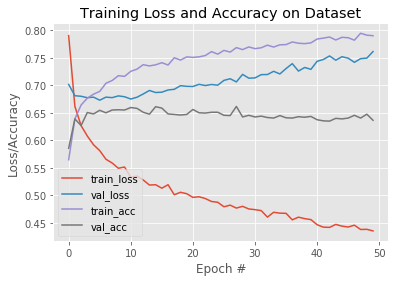

In [17]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=X_test.astype("float32"), batch_size=32)
print(classification_report(y_test.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))
# plot the training loss and accuracy
N = epcohs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

In [18]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save("model/activity.model", save_format="h5")
# serialize the label binarizer to disk
f = open("model/lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()
print("[INFO] Save Completed...")

[INFO] serializing network...
[INFO] Save Completed...


In [19]:
# y_train = pd.get_dummies(train_class)
# y_test = pd.get_dummies(test_class)

# y_train.shape

In [20]:
# # creating the base model of pre-trained VGG16 model
# base_model = VGG16(weights='imagenet', include_top=False)

In [21]:
# # extracting features for training frames
# X_train = base_model.predict(X_train)
# X_train.shape

In [22]:
# # extracting features for validation frames
# X_test = base_model.predict(X_test)
# X_test.shape

In [23]:
# # reshaping the training as well as validation frames in single dimension
# X_train = X_train.reshape(150, 7*7*512)
# X_test = X_test.reshape(150, 7*7*512)

In [24]:
# # normalizing the pixel values
# max = X_train.max()
# X_train = X_train/max
# X_test = X_test/max

In [25]:
# # shape of images
# X_train.shape

In [26]:
# #defining the model architecture
# model = Sequential()
# model.add(Dense(1024, activation='relu', input_shape=(25088,)))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(101, activation='softmax'))

In [27]:
# # defining a function to save the weights of best model
# from keras.callbacks import ModelCheckpoint
# mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [28]:
# # compiling the model
# model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])